---

# Crime and Economic Analysis Project (2024)

## Overview

This project explores the relationship between crime incidents and socioeconomic factors in Washington, D.C. throughout 2024. By integrating open crime data with economic indicators at the neighborhood level, the goal is to uncover patterns in criminal activity and assess the feasibility of predictive modeling for both violent and non-violent crimes.


## Objectives

- **Understand the structure of crime in D.C.**  
  Use data visualizations and exploratory analysis to identify trends across time, geography, and crime categories.

- **Integrate economic context**  
  Combine crime data with key economic features (e.g., income, education level, unemployment, poverty rate) at the ANC or Ward level to add explanatory power.

- **Build predictive models**  
  1. Classify incidents as **violent vs. non-violent** crimes.  
  2. For non-violent crimes, predict the **specific type** (e.g., burglary, theft, motor vehicle theft).

- **Test machine learning approaches**  
  Evaluate classifiers such as Random Forest and XGBoost for binary and multi-class classification tasks using labeled data.


## Methodology Summary

1. **Data Cleaning and Normalization**  
   - Remove nulls and duplicates, normalize column names, convert timestamps.

2. **Smart Imputation**  
   - Use similarity-based logic to fill essential join fields for improved data integration.

3. **Exploratory Data Analysis (EDA)**  
   - Visualize distributions, trends, and spatial patterns in crime incidents.

4. **Economic Data Integration**  
   - Join socioeconomic indicators to crime records via geographic fields.

5. **Machine Learning**  
   - Train and evaluate classification models with a focus on interpretability and performance (e.g., accuracy, F1-score).


## Why It Matters

By enriching crime data with economic indicators and applying predictive analytics, this project demonstrates how data science can:
- Help city planners and law enforcement allocate resources more effectively.
- Highlight social and economic conditions linked to crime patterns.
- Serve as a foundation for more robust, community-centered public safety strategies.

## **Datasets Used**:

- `Crime_Incidents_in_2024.csv`: Crime records with location, type, method, and shift.
- Publicly available economic data by ANC or Ward.

 **Tools**:
- Python (pandas, seaborn, scikit-learn, XGBoost, matplotlib)
- Jupyter Notebooks

---
#

---
# Crime Data 

## Load Crime Data
This section loads and begins cleaning the primary crime dataset. It involves parsing dates, normalizing column names, and dropping null values to prepare for analysis.

In [1]:
import os


In [3]:
import pandas as pd

# Portable relative path to the CSV
csv_path = os.path.join("Data In", "Crime_Incidents_in_2024.csv")

# Load the file
df_crime = pd.read_csv(csv_path)
print(f" Loaded: {csv_path}")
df_crime.info()

 Loaded: Data In/Crime_Incidents_in_2024.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29294 entries, 0 to 29293
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   X                     29294 non-null  float64
 1   Y                     29294 non-null  float64
 2   CCN                   29294 non-null  int64  
 3   REPORT_DAT            29294 non-null  object 
 4   SHIFT                 29294 non-null  object 
 5   METHOD                29294 non-null  object 
 6   OFFENSE               29294 non-null  object 
 7   BLOCK                 29294 non-null  object 
 8   XBLOCK                29294 non-null  float64
 9   YBLOCK                29294 non-null  float64
 10  WARD                  29290 non-null  float64
 11  ANC                   29290 non-null  object 
 12  DISTRICT              28549 non-null  float64
 13  PSA                   28826 non-null  float64
 14  NEIGHBORHOOD_CLUSTER  292

In [5]:
# Drop columns that are fully null or not useful
df_crime = df_crime.drop(columns=['OCTO_RECORD_ID', 'BID'], errors='ignore')


In [7]:
# Check the percentage of missing data
missing_percent = (df_crime.isnull().mean() * 100).round(2).sort_values(ascending=False)
missing_summary = missing_percent[missing_percent > 0]
print("Missing Data Summary:")
print(missing_summary)


Missing Data Summary:
END_DATE                7.15
DISTRICT                2.54
PSA                     1.60
CENSUS_TRACT            0.04
BLOCK_GROUP             0.04
START_DATE              0.02
ANC                     0.01
VOTING_PRECINCT         0.01
NEIGHBORHOOD_CLUSTER    0.01
WARD                    0.01
dtype: float64


## Smart Imputation for Join Fields Using Similarity

This section addresses the issue of missing or inconsistent values in key fields required for joining datasets—specifically geographic or administrative identifiers like ANC (Advisory Neighborhood Commission) or Ward. Incomplete join fields can lead to data loss or mismatched merges when combining crime data with external sources such as economic indicators.

### Intent
The primary goal is to **minimize data loss during joins** by intelligently filling in missing or malformed join fields. Rather than simply dropping rows or using arbitrary default values, this approach leverages **string similarity** or **related context fields** to make educated guesses about the missing data.

### Methodology
- **String similarity measures**  are used to find the closest matching known values.
- Alternatively, rows with missing join fields may be imputed using related fields (e.g., using neighborhood or coordinates to infer ANC).
- This maintains the integrity of the data merge process, ensuring that as much data as possible is aligned with the socioeconomic indicators.

### Benefit
This step **improves the completeness of the integrated dataset**, enabling more accurate downstream analysis and machine learning models by preserving a higher proportion of the original records.


In [11]:
# Smart imputation for essential join fields using similarity
from collections import Counter

columns_to_impute = ['CENSUS_TRACT', 'BLOCK_GROUP', 'DISTRICT', 'PSA']
comparison_features_base = ['WARD', 'BLOCK', 'XBLOCK', 'YBLOCK',
                            'NEIGHBORHOOD_CLUSTER', 'VOTING_PRECINCT', 'ANC']

# Create a working copy
df_crime_impute = df_crime.copy()

for target_col in columns_to_impute:
    print(f"\nImputing missing values for: {target_col}")
    comparison_features = [f for f in comparison_features_base if f != target_col]
    known = df_crime_impute[df_crime_impute[target_col].notnull()]
    missing = df_crime_impute[df_crime_impute[target_col].isnull()]

    filled = 0
    for idx, row in missing.iterrows():
        matches = known[comparison_features].eq(row[comparison_features]).sum(axis=1)
        best_match_indices = matches[matches >= 5].index
        if not best_match_indices.empty:
            most_common = Counter(known.loc[best_match_indices, target_col]).most_common(1)
            if most_common:
                df_crime_impute.at[idx, target_col] = most_common[0][0]
                filled += 1
    print(f"Filled {filled} missing '{target_col}' values using 5+ feature matches.")



Imputing missing values for: CENSUS_TRACT
Filled 2 missing 'CENSUS_TRACT' values using 5+ feature matches.

Imputing missing values for: BLOCK_GROUP
Filled 2 missing 'BLOCK_GROUP' values using 5+ feature matches.

Imputing missing values for: DISTRICT
Filled 698 missing 'DISTRICT' values using 5+ feature matches.

Imputing missing values for: PSA
Filled 439 missing 'PSA' values using 5+ feature matches.


In [12]:
# Fill minimal missing values with 'Unknown'
fill_with_unknown = ['WARD', 'ANC', 'VOTING_PRECINCT', 'NEIGHBORHOOD_CLUSTER']
df_crime_impute[fill_with_unknown] = df_crime_impute[fill_with_unknown].fillna("Unknown")

In [13]:
import os

# Final check for remaining missing values
print("Remaining missing values:")
print(df_crime_impute.isnull().sum().sort_values(ascending=False))

# Ensure the Data Out folder exists
os.makedirs("Data Out", exist_ok=True)

# Save the cleaned file
output_path = os.path.join("Data Out", "Crime_Incidents_2024_CLEANED.csv")
df_crime_impute.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to '{output_path}'")


Remaining missing values:
END_DATE                2094
DISTRICT                  47
PSA                       29
CENSUS_TRACT              11
BLOCK_GROUP               11
START_DATE                 6
X                          0
LONGITUDE                  0
LATITUDE                   0
VOTING_PRECINCT            0
NEIGHBORHOOD_CLUSTER       0
ANC                        0
Y                          0
WARD                       0
YBLOCK                     0
XBLOCK                     0
BLOCK                      0
OFFENSE                    0
METHOD                     0
SHIFT                      0
REPORT_DAT                 0
CCN                        0
OBJECTID                   0
dtype: int64
Cleaned dataset saved to 'Data Out/Crime_Incidents_2024_CLEANED.csv'


In [14]:
# Generate the shape of the dataframe
print("\nSummary Statistics:")
print(df_crime_impute.shape)


Summary Statistics:
(29294, 23)


## Exploratory Analysis: Understanding Crime Patterns

The following blocks and visualizations are designed to **deepen our understanding of the crime dataset**. After cleaning and imputing missing data, it's essential to explore the structure and distribution of the data before proceeding with modeling.

### Intent
These cells aim to:
- Identify **patterns and trends** across time, location, and crime type.
- Detect **imbalances** in the data (e.g., frequency of violent vs. non-violent crimes).
- Visualize the **spatial distribution** of crimes using maps and groupings by neighborhoods or districts.
- Examine **temporal trends**, such as changes by year, month, or hour of the day.

This step lays the groundwork for informed feature engineering and helps uncover potential biases or gaps in the data.

### Outcome
The insights gained here **guide the selection of predictive features** and ensure that model design aligns with the underlying data characteristics.

In [17]:
import pandas as pd
import os

# Load the cleaned dataset from the Data Out folder
input_path = os.path.join("Data Out", "Crime_Incidents_2024_CLEANED.csv")
df_crime_cleaned = pd.read_csv(input_path)

# Define violent crime categories
violent_offenses = ["HOMICIDE", "SEX ABUSE", "ASSAULT W/DANGEROUS WEAPON", "ROBBERY", "ARSON"]

# Add classification column
df_crime_cleaned["VIOLENT"] = df_crime_cleaned["OFFENSE"].apply(
    lambda x: "Violent" if str(x).strip().upper() in violent_offenses else "Non-Violent"
)

# Count and percentage distribution
violent_counts = df_crime_cleaned["VIOLENT"].value_counts()
violent_percent = df_crime_cleaned["VIOLENT"].value_counts(normalize=True) * 100

violent_counts, violent_percent


(VIOLENT
 Non-Violent    25826
 Violent         3468
 Name: count, dtype: int64,
 VIOLENT
 Non-Violent    88.161398
 Violent        11.838602
 Name: proportion, dtype: float64)

/var/folders/bd/h6f2p4l532x5vk1qlz9890r00000gn/T/ipykernel_24854/3675120852.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_crime_cleaned, x="VIOLENT", palette="pastel")


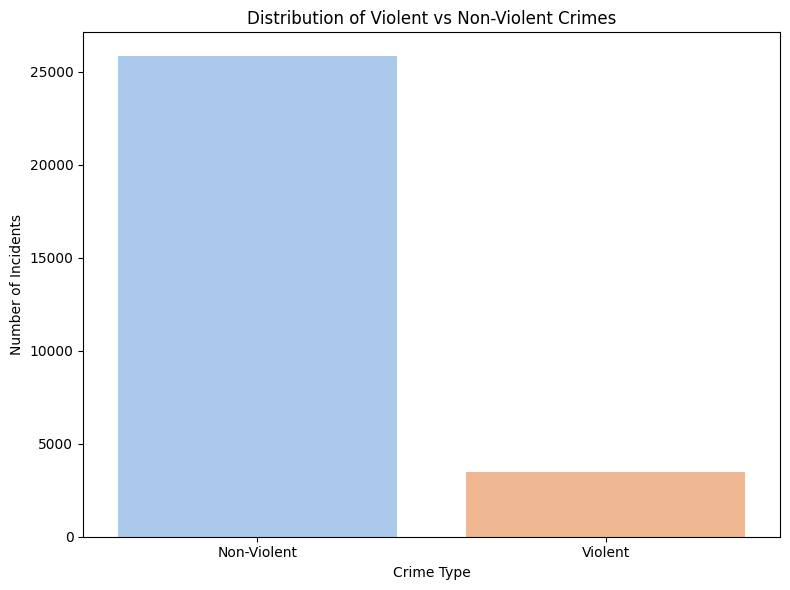

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(8, 6))
sns.countplot(data=df_crime_cleaned, x="VIOLENT", palette="pastel")
plt.title("Distribution of Violent vs Non-Violent Crimes")
plt.xlabel("Crime Type")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.show()


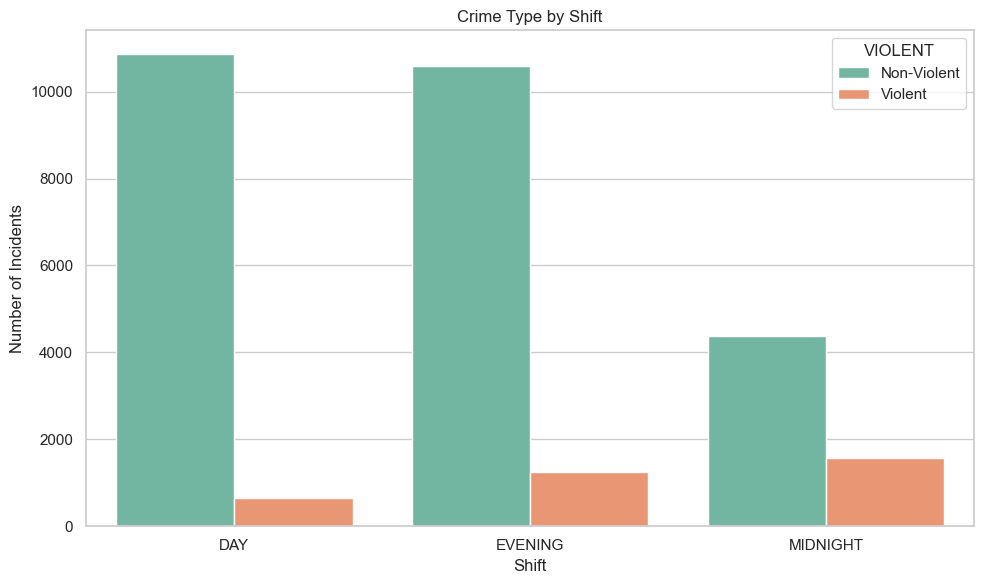

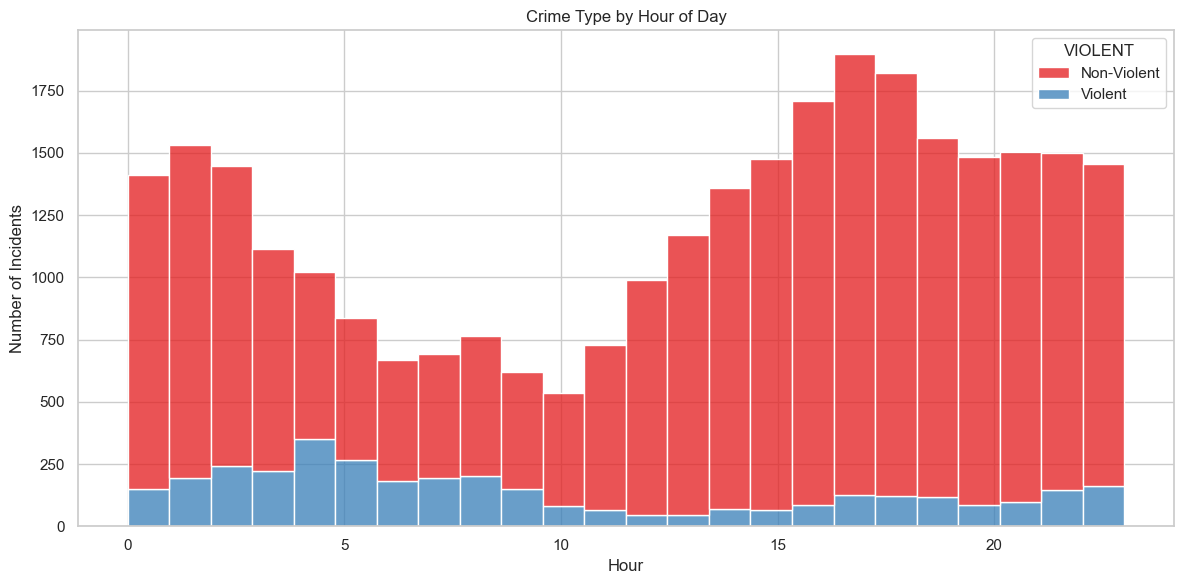

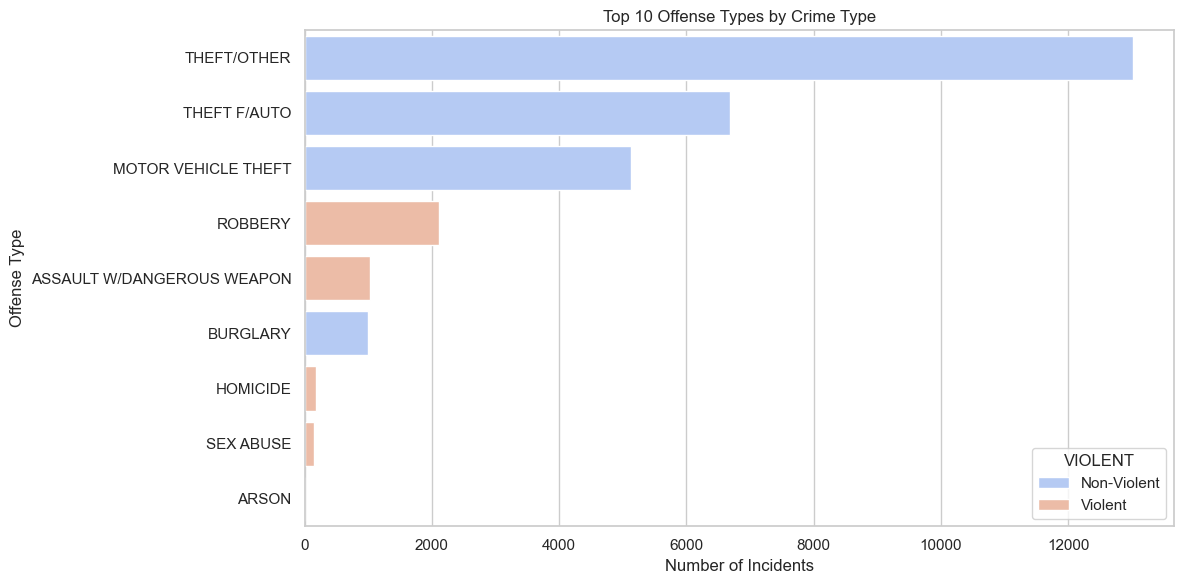

In [24]:
# Create three separate plots: by SHIFT, by HOUR, and by OFFENSE type

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure hour column exists
df_crime_cleaned["REPORT_DAT"] = pd.to_datetime(df_crime_cleaned["REPORT_DAT"], errors='coerce')
df_crime_cleaned["HOUR"] = df_crime_cleaned["REPORT_DAT"].dt.hour

# Set plot style
sns.set(style="whitegrid")

# Plot: Violent vs Non-Violent by SHIFT
plt.figure(figsize=(10, 6))
sns.countplot(data=df_crime_cleaned, x="SHIFT", hue="VIOLENT", palette="Set2")
plt.title("Crime Type by Shift")
plt.xlabel("Shift")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.show()

# Plot: Violent vs Non-Violent by Hour of Day
plt.figure(figsize=(12, 6))
sns.histplot(data=df_crime_cleaned, x="HOUR", hue="VIOLENT", multiple="stack", bins=24, palette="Set1")
plt.title("Crime Type by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Incidents")
plt.tight_layout()
plt.show()

# Plot: Top 10 Offense Types by Crime Type
top_offenses = df_crime_cleaned["OFFENSE"].value_counts().head(10).index
plt.figure(figsize=(12, 6))
sns.countplot(data=df_crime_cleaned[df_crime_cleaned["OFFENSE"].isin(top_offenses)],
              y="OFFENSE", hue="VIOLENT", palette="coolwarm")
plt.title("Top 10 Offense Types by Crime Type")
plt.xlabel("Number of Incidents")
plt.ylabel("Offense Type")
plt.tight_layout()
plt.show()


<Figure size 1000x1000 with 0 Axes>

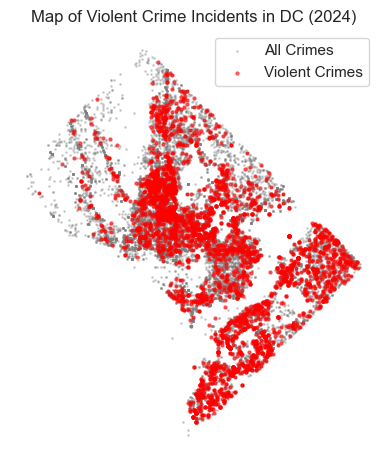

In [26]:
import geopandas as gpd

# Ensure latitude and longitude are present and non-null
df_geo = df_crime_cleaned.dropna(subset=["LATITUDE", "LONGITUDE"]).copy()

# Create a GeoDataFrame from lat/lon
gdf_crime = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo["LONGITUDE"], df_geo["LATITUDE"]),
    crs="EPSG:4326"  # WGS 84
)

# Filter to violent crimes only
gdf_violent = gdf_crime[gdf_crime["VIOLENT"] == "Violent"]

# Plot the distribution of violent crimes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
base = gdf_crime.plot(color="grey", markersize=1, alpha=0.3, label="All Crimes")
gdf_violent.plot(ax=base, color="red", markersize=5, alpha=0.5, label="Violent Crimes")

plt.title("Map of Violent Crime Incidents in DC (2024)")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()


The map visualizes 2024 crime incidents in Washington, DC, distinguishing violent crimes (red) from all crimes (gray). Violent crimes appear densely clustered in central and southeastern areas, suggesting potential hotspots, while fewer incidents occur in the northwest and peripheral regions. This overlay enables a clear spatial comparison, highlighting where violent activity is most concentrated relative to general crime. The visualization offers an effective way to identify high-risk zones

---

# Economic Data 
Here, economic indicators (e.g., income, education, poverty) are merged with the crime data by geographic keys. The goal is to enrich crime data with socioeconomic context for better model performance.

## Understanding American Community Survey (ACS) Data Integration: DP02, DP03, DP04

### Background on the American Community Survey (ACS)

The **American Community Survey (ACS)** is a continuous survey conducted by the U.S. Census Bureau that provides vital demographic, housing, social, and economic information every year. The **Detailed Profile (DP)** tables from the ACS are pre-aggregated datasets that summarize key statistics across different domains:

- **DP02**: Social Characteristics (e.g., educational attainment, marital status, language spoken at home)
- **DP03**: Economic Characteristics (e.g., income, employment status, industry sector)
- **DP04**: Housing Characteristics (e.g., occupancy, housing value, rent burden)

Each dataset is accompanied by a **metadata file** that provides column labels, codes, and descriptions needed to interpret the numeric column headers in the CSV data files.


### Summary

Using ACS data via DP02–DP04 enriched our crime dataset with **contextual socioeconomic features**, enabling more insightful modeling. While DP05 was omitted for ethical reasons, the integration of ACS data presented both **valuable opportunities and practical data engineering challenges** that shaped the final analytic pipeline.

## Why These Tables Were Selected

The selected tables provide **rich, structured socioeconomic context** that is potentially relevant for understanding and predicting crime patterns:

- **DP02 (Social)**: Educational levels and family structures may influence crime rates or neighborhood stability.
- **DP03 (Economic)**: Employment status and income are directly tied to economic stressors often linked with crime.
- **DP04 (Housing)**: Metrics such as rent burden or overcrowding serve as proxies for urban stress and instability.

These variables allow us to move beyond location and time and incorporate **structural socioeconomic features** into our machine learning models.

## Why DP05 Was Not Used

**DP05** focuses on **demographic profiles**—including race, age, and sex breakdowns. While these are important for population-level studies, we excluded DP05 from the modeling for the following reasons:

- **Ethical and bias concerns**: Including race/ethnicity in predictive models related to crime can reinforce harmful stereotypes or lead to biased outcomes.
- **Policy considerations**: Crime prediction models using race can violate responsible AI principles and are often rejected in governance or operational settings.
- **Model interpretability and fairness**: Excluding DP05 ensures our models focus on **systemic economic and social factors** rather than demographic identity.

## Challenges in Joining ACS Data

Integrating ACS data with crime records required careful preprocessing due to:

- **Geographic mismatch**: ACS data is typically provided at the **census tract**, **block group**, or **ANC/Ward** level. Crime data often contains inconsistent or missing identifiers for these fields.
- **Column normalization**: The ACS datasets use encoded column names (e.g., `DP03_0062E`) which must be decoded using accompanying metadata to become meaningful.
- **Missing values and inconsistency**: Some areas have suppressed or estimated values, particularly in less populous neighborhoods.
- **Non-1:1 joins**: Not all crime incidents neatly match a single economic profile; assumptions and imputations were necessary to align data correctly.

## DP02 Load - **DP02**: Social Characteristics (e.g., educational attainment, marital status, language spoken at home)

In [40]:
#loading cleaned crime into pandas dataframe

# Join folder and filename
cc_path = os.path.join("Data In", "cleaned_crime.csv")

# Load the CSV
cc = pd.read_csv(cc_path)
cc.head(2)

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,...,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,START_DATE,END_DATE,OBJECTID,geometry
0,399622.2700,134352.62,24093246,2024/06/19 14:52:56+00,DAY,OTHERS,THEFT/OTHER,1100 - 1199 BLOCK OF NEW JERSEY AVENUE SE,399622.270000,134352.620000,...,Cluster 27,007203 1,7203.0,Precinct 131,38.877004,-77.004353,2024-06-19 14:50:00+00:00,2024-06-19 14:52:00+00:00,679448603,POINT (-77.004353141 38.8770044023)
1,398579.1351,134828.40,24131497,2024/08/27 01:13:37+00,EVENING,OTHERS,THEFT F/AUTO,300 - 399 BLOCK OF G STREET SW,398579.135069,134828.399995,...,Cluster 9,010500 2,10500.0,Precinct 128,38.881289,-77.016376,2024-08-26 18:51:00+00:00,2024-08-26 20:14:00+00:00,679448604,POINT (-77.0163757098 38.8812893478)


In [42]:
#loading dp_o2 dataset which is corresponding to Social Life (education, marriage, language, disability)

# Join folder and filename
dp_02_path = os.path.join("Data In", "dp_02.csv")

# Load the CSV
dp_02 = pd.read_csv(dp_02_path)
pd.set_option('display.max_columns',None)
dp_02.head(2)

,TRACTCE,GEOID,NAME,DP02_0001E,DP02_0002E,DP02_0003E,DP02_0004E,DP02_0005E,DP02_0006E,DP02_0007E,DP02_0008E,DP02_0009E,DP02_0010E,DP02_0011E,DP02_0012E,DP02_0013E,DP02_0014E,DP02_0015E,DP02_0016E,DP02_0017E,DP02_0018E,DP02_0019E,DP02_0020E,DP02_0021E,DP02_0022E,DP02_0023E,DP02_0024E,DP02_0025E,DP02_0026E,DP02_0027E,DP02_0028E,DP02_0029E,DP02_0030E,DP02_0031E,DP02_0032E,DP02_0033E,DP02_0034E,DP02_0035E,DP02_0036E,DP02_0037E,DP02_0038E,DP02_0039E,DP02_0040E,DP02_0041E,DP02_0042E,DP02_0043E,DP02_0044E,DP02_0045E,DP02_0046E,DP02_0047E,DP02_0048E,DP02_0049E,DP02_0050E,DP02_0051E,DP02_0052E,DP02_0053E,DP02_0054E,DP02_0055E,DP02_0056E,DP02_0057E,DP02_0058E,DP02_0059E,DP02_0060E,DP02_0061E,DP02_0062E,DP02_0063E,DP02_0064E,DP02_0065E,DP02_0066E,DP02_0067E,DP02_0068E,DP02_0069E,DP02_0070E,DP02_0071E,DP02_0072E,DP02_0073E,DP02_0074E,DP02_0075E,DP02_0076E,DP02_0077E,DP02_0078E,DP02_0079E,DP02_0080E,DP02_0081E,DP02_0082E,DP02_0083E,DP02_0084E,DP02_0085E,DP02_0086E,DP02_0087E,DP02_0088E,DP02_0089E,DP02_0090E,DP02_0091E,DP02_0092E,DP02_0093E,DP02_0094E,DP02_0095E,DP02_0096E,DP02_0097E,DP02_0098E,DP02_0099E,DP02_0100E,DP02_0101E,DP02_0102E,DP02_0103E,DP02_0104E,DP02_0105E,DP02_0106E,DP02_0107E,DP02_0108E,DP02_0109E,DP02_0110E,DP02_0111E,DP02_0112E,DP02_0113E,DP02_0114E,DP02_0115E,DP02_0116E,DP02_0117E,DP02_0118E,DP02_0119E,DP02_0120E,DP02_0121E,DP02_0122E,DP02_0123E,DP02_0124E,DP02_0125E,DP02_0126E,DP02_0127E,DP02_0128E,DP02_0129E,DP02_0130E,DP02_0131E,DP02_0132E,DP02_0133E,DP02_0134E,DP02_0135E,DP02_0136E,DP02_0137E,DP02_0138E,DP02_0139E,DP02_0140E,DP02_0141E,DP02_0142E,DP02_0143E,DP02_0144E,DP02_0145E,DP02_0146E,DP02_0147E,DP02_0148E,DP02_0149E,DP02_0150E,DP02_0151E,DP02_0152E,DP02_0153E,DP02_0154E,GIS_ID,SE_ANNO_CAD_DATA,GLOBALID,OBJECTID,STATEFP,COUNTYFP,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,SHAPEAREA,SHAPELEN
0,5302,11001005302,53.02,1606,354,127,91,10,719,0,492,68,442,0,424,42,137,159,1.59,2.86,2547,1606,407,86,269,0,179,1327,846,422,0,20,39,951,520,365,17,15,34,34,0,0.0,43.0,NaN,62.0,0.0,0,0,0,0,0,0,0,0,0,278,97,8,43,0,130,2091,13,0,67,15,22,884,1090,2078,1974,2262,36,2531,74,269,0,2050,51,212,23,2512,1720,792,728,390,338,0,338,64,2547,2127,2110,268,1842,17,420,420,163,257,437,17,0,17,420,206,214,420,198,149,0,0,73,0,2329,1826,503,38,121,20,213,0,169,18,0,0,2547,131,15,38,0,0,254,99,0,308,34,0,407,247,0,0,80,11,12,27,117,0,46,16,8,11,12,0,1606,1606,1506,ACS_Social_DC_CensusTract_1,NaN,{C706486F-3B00-45B7-B12E-4A056EE6EA51},1,11,1,1400000US11001005302,Census Tract 53.02,G5020,S,117635,0,38.912452,-77.038644,0,0
1,4402,11001004402,44.02,1234,374,132,134,0,423,0,230,37,303,33,182,0,165,138,2.02,2.75,2487,1234,377,109,252,206,309,1213,551,548,14,0,100,1065,804,248,0,0,13,76,33,49.0,92.0,0.0,119.0,0.0,0,0,0,0,0,0,0,0,0,246,7,22,46,5,166,2014,3,18,196,96,80,604,1017,1993,1621,2259,11,2480,202,223,0,2055,199,202,3,2434,2037,397,387,207,180,0,180,10,2503,2209,2091,472,1619,118,294,294,194,100,412,118,87,31,294,107,187,294,53,98,43,0,83,17,2346,1889,457,83,125,0,121,42,69,0,142,41,2503,20,146,0,0,0,243,35,0,319,0,11,324,67,43,0,29,23,11,8,46,4,43,30,14,33,14,0,1234,1234,1234,ACS_Social_DC_CensusTract_2,NaN,{E7A2C3A6-6531-4010-AF6E-80E683E34757},2,11,1,1400000US11001004402,Census Tract 44.02,G5020,S,274746,0,38.915515,-77.027035,0,0


We are going to assign demographic information (from Census Tracts) to individual records (like crimes, events, or points) based on their latitude and longitude.
we are going to do this by
1) Mapping points to their census tract area (spatial join)

2) Merging demographic attributes into our main dataset.


In [45]:
# 1. Import Required Libraries
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point

# 2. Load Census Tract Shapefile
# Relative path to shapefile from notebook location
shapefile_path = os.path.join(
    "Data In",
    "ACS_5-Year_Demographic_Characteristics_DC_Census_Tract",
    "ACS_5-Year_Demographic_Characteristics_DC_Census_Tract.shp"
)

# Load shapefile
tracts_gdf = gpd.read_file(shapefile_path)

# 3. Reproject Census Tracts to WGS84 (Latitude/Longitude)
tracts_gdf = tracts_gdf.to_crs(epsg=4326)

# 4. Ensure Consistent GEOID Data Types
tracts_gdf['GEOID'] = tracts_gdf['GEOID'].astype(str)
dp_02['GEOID'] = dp_02['GEOID'].astype(str)

# 5. Convert 'cc' DataFrame (event records) to a GeoDataFrame
cc['geometry'] = cc.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
cc_gdf = gpd.GeoDataFrame(cc, geometry='geometry', crs="EPSG:4326")

# 6. Perform Spatial Join: Assign Census Tract to Each Event
cc_with_tracts = gpd.sjoin(
    cc_gdf,
    tracts_gdf[['GEOID', 'geometry']],
    how='left',
    predicate='within'
)

# 7. Merge Demographic Data Based on GEOID
cc_final = cc_with_tracts.merge(dp_02, on='GEOID', how='left')

# 8. Clean Up Unnecessary Columns
cc_final = cc_final.drop(columns=['geometry', 'index_right'])

# 9. Review the Final Dataset
#print(cc_final.head(2))
#print(f"Merged dataset shape: {cc_final.shape}")

In [47]:
# calculating single_parent_percent, to do that we are going to use codes 
# DP02_0007E -HOUSEHOLDS BY TYPE!!Total households!!Family households (families),
#family!!With own children under 18 years

# DP02_0011E HOUSEHOLDS BY TYPE!!Total households!!Nonfamily households!!Householder living alone
#DP02_0001E - Total households 
cc_final['single_parent_rate'] = (
    (cc_final['DP02_0007E'] + cc_final['DP02_0011E']) / cc_final['DP02_0001E']
)
cc_final['single_parent_rate_percent'] = cc_final['single_parent_rate'] * 100
# print(cc_final['single_parent_rate_percent'])

#DP02_0080E - Population 1 year and over!!Same house
#DP02_0081E - Population 1 year and over!!Different house in the U.S.
cc_final = cc_final.rename(columns={
    'DP02_0080E': 'same_house',
    'DP02_0081E': 'different_house'
})
cc_final['total_population_1yr_plus'] = cc_final['same_house'] + cc_final['different_house']
cc_final['residential_mobility_rate'] = (cc_final['different_house'] / cc_final['total_population_1yr_plus']) * 100
#print(cc_final[['same_house', 'different_house', 'residential_mobility_rate']].head(2))

#DP02_0059E - EDUCATIONAL ATTAINMENT!!Population 25 years and over

#DP02_0060E - Population 25 years and over!!Less than 9th grade
#DP02_0061E-EDUCATIONAL ATTAINMENT!!Population 25 years and over!!9th to 12th grade, no diploma
#DP02_0068E-Population 25 years and over!!Bachelor's degree or higher
cc_final['less_than_hs_pct'] = (
    (cc_final['DP02_0060E'] + cc_final['DP02_0061E']) / cc_final['DP02_0059E']
) * 100
cc_final['bachelors_or_higher_pct'] = (
    cc_final['DP02_0068E'] / cc_final['DP02_0059E']
) * 100
#print(cc_final['less_than_hs_pct'])
#print(cc_final['bachelors_or_higher_pct'])

# Percent born in same state
#DP02_0088E	Estimate!!PLACE OF BIRTH!!Total population!!Native
#DP02_0091E	Estimate!!PLACE OF BIRTH!!Total population!!Native!!Born in United States!!Different state
cc_final['percent born in same state'] = (1 - (cc_final['DP02_0091E'] / cc_final['DP02_0088E'])) * 100
#print(cc_final['percent born in same state'])
cc_final['percent_born_in_different_state'] = (cc_final['DP02_0091E'] / cc_final['DP02_0088E']) * 100
#print(cc_final['percent_born_in_different_state'])

#DP02_0094E	Estimate!!U.S. CITIZENSHIP STATUS!!Foreign-born population
cc_final['percent foreign born'] = (cc_final['DP02_0094E'] / cc_final['DP02_0088E']) * 100
#cc_final['percent foreign born']

cc_final['avg_household_size'] = cc_final['DP02_0016E']
#print(cc_final['avg_household_size'])


In [49]:
cc_final.isnull().sum()

X                                    0
Y                                    0
CCN                                  0
REPORT_DAT                           0
SHIFT                                0
                                  ... 
bachelors_or_higher_pct            135
percent born in same state         135
percent_born_in_different_state    135
percent foreign born               135
avg_household_size                 205
Length: 206, dtype: int64

In [51]:
# List of columns to fill
columns_to_fill = [
    'less_than_hs_pct', 
    'bachelors_or_higher_pct', 
    'percent born in same state', 
    'percent foreign born', 
    'avg_household_size',
    'single_parent_rate_percent', 
    'residential_mobility_rate',
    'percent_born_in_different_state'
]

# Fill missing values with mean for each column
for col in columns_to_fill:
    mean_value = cc_final[col].mean()
    cc_final[col] = cc_final[col].fillna(mean_value)

# Confirm no missing values remain
print(cc_final[columns_to_fill].isnull().sum())

less_than_hs_pct                   0
bachelors_or_higher_pct            0
percent born in same state         0
percent foreign born               0
avg_household_size                 0
single_parent_rate_percent         0
residential_mobility_rate          0
percent_born_in_different_state    0
dtype: int64


In [53]:
cc_final.shape

(29224, 206)

In [55]:
# Columns you want to keep
columns_to_keep = [
    'X','Y','CCN', 'REPORT_DAT', 'SHIFT', 'METHOD',
    'OFFENSE', 'BLOCK','XBLOCK', 'YBLOCK', 'WARD', 'ANC',
    'DISTRICT', 'PSA','NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP', 'CENSUS_TRACT',
    'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE', 'START_DATE', 'END_DATE',
    'single_parent_rate_percent',
    'residential_mobility_rate',
    'less_than_hs_pct',
    'bachelors_or_higher_pct',
    'percent born in same state',
    'percent foreign born',
    'avg_household_size',
    'percent_born_in_different_state'
]

# Keep only those columns in the DataFrame
cc_final = cc_final[columns_to_keep]

# Confirm result
#print(cc_final.head())
#print(f"Remaining columns: {cc_final.columns.tolist()}")

## DP03 Load - **DP03**: Economic Characteristics (e.g., income, employment status, industry sector)

In [59]:
#loading dp_o2 dataset which is corresponding to Social Life (education, marriage, language, disability)

# Join folder and filename
dp_03_path = os.path.join("Data In", "dp_03.csv")

# Load the CSV
dp03 = pd.read_csv(dp_03_path)
pd.set_option('display.max_columns',None)
dp03.head(2)

,TRACTCE,GEOID,NAME,DP03_0001E,DP03_0002E,DP03_0003E,DP03_0004E,DP03_0005E,DP03_0006E,DP03_0007E,DP03_0008E,DP03_0010E,DP03_0011E,DP03_0012E,DP03_0013E,DP03_0014E,DP03_0015E,DP03_0016E,DP03_0017E,DP03_0018E,DP03_0019E,DP03_0020E,DP03_0021E,DP03_0022E,DP03_0023E,DP03_0024E,DP03_0025E,DP03_0026E,DP03_0027E,DP03_0028E,DP03_0029E,DP03_0030E,DP03_0031E,DP03_0032E,DP03_0033E,DP03_0034E,DP03_0035E,DP03_0036E,DP03_0037E,DP03_0038E,DP03_0039E,DP03_0040E,DP03_0041E,DP03_0042E,DP03_0043E,DP03_0044E,DP03_0045E,DP03_0046E,DP03_0047E,DP03_0048E,DP03_0049E,DP03_0050E,DP03_0051E,DP03_0052E,DP03_0053E,DP03_0054E,DP03_0055E,DP03_0056E,DP03_0057E,DP03_0058E,DP03_0059E,DP03_0060E,DP03_0061E,DP03_0062E,DP03_0063E,DP03_0064E,DP03_0065E,DP03_0066E,DP03_0067E,DP03_0068E,DP03_0069E,DP03_0070E,DP03_0071E,DP03_0072E,DP03_0073E,DP03_0074E,DP03_0075E,DP03_0076E,DP03_0077E,DP03_0078E,DP03_0079E,DP03_0080E,DP03_0081E,DP03_0082E,DP03_0083E,DP03_0084E,DP03_0085E,DP03_0086E,DP03_0087E,DP03_0088E,DP03_0089E,DP03_0090E,DP03_0091E,DP03_0092E,DP03_0093E,DP03_0094E,DP03_0095E,DP03_0096E,DP03_0097E,DP03_0098E,DP03_0099E,DP03_0100E,DP03_0101E,DP03_0102E,DP03_0103E,DP03_0104E,DP03_0105E,DP03_0106E,DP03_0107E,DP03_0108E,DP03_0109E,DP03_0110E,DP03_0111E,DP03_0112E,DP03_0113E,DP03_0114E,DP03_0115E,DP03_0116E,DP03_0117E,DP03_0118E,GIS_ID,SE_ANNO_CAD_DATA,GLOBALID,OBJECTID,STATEFP,COUNTYFP,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,DP03_0009PE,DP03_0119PE,DP03_0120PE,DP03_0121PE,DP03_0122PE,DP03_0123PE,DP03_0124PE,DP03_0125PE,DP03_0126PE,DP03_0127PE,DP03_0128PE,DP03_0129PE,DP03_0130PE,DP03_0131PE,DP03_0132PE,DP03_0133PE,DP03_0134PE,DP03_0135PE,DP03_0136PE,DP03_0137PE,SHAPEAREA,SHAPELEN
0,5302,11001005302,53.02,2278,1975,1959,1959,0,16,303,1959,951,844,844,844,226,226,43,43,1915,182,28,431,416,55,803,31.2,1959,1692,40,219,0,8,1959,0,39,0,27,84,21,86,176,769,124,73,158,402,1959,1408,487,64,0,1606,10,0,84,34,118,129,162,314,244,511,138241.0,194101.0,1438,188740.0,141,22222.0,115,104794.0,0,NaN,11,NaN,12,364,0,10,0,0,0,11,0,12,24,307,250001.0,425624.0,124569.0,1242,111082.0,126069.0,111155.0,121979.0,110305.0,2531,2456,2331,325,75,269,0,2050,1917,1917,1907,1875,58,10,0,0,0,0,0,133,68,61,7,65,ACS_Economic_DC_CensusTract_1,NaN,{7551F957-2E31-475F-971F-6076920A35A2},1,11,1,1400000US11001005302,Census Tract 53.02,G5020,S,117635,0,38.912452,-77.038644,0.0,2.7,7.3,9.8,0.0,0.0,0.0,100.0,100.0,100.0,1.9,4.1,4.1,5.0,0.0,1.7,1.5,3.3,2.0,1.9,0,0
1,4402,11001004402,44.02,2275,1810,1794,1690,104,16,465,1794,1062,857,857,753,179,136,44,0,1663,540,67,337,200,65,454,26.2,1690,1360,56,159,57,58,1690,0,8,9,0,102,14,61,104,645,159,28,219,341,1690,1129,459,102,0,1234,6,0,19,33,53,99,130,189,224,481,177902.0,247255.0,1172,241012.0,58,44517.0,144,53045.0,77,NaN,90,NaN,107,477,6,0,0,33,0,57,20,35,111,215,182413.0,273324.0,116166.0,757,157574.0,226709.0,96736.0,134759.0,97614.0,2480,2426,2017,554,54,223,0,2055,1767,1663,1609,1493,130,54,104,104,7,97,0,288,288,180,108,0,ACS_Economic_DC_CensusTract_2,NaN,{65AD956B-4F52-4F3D-9388-04F3E949CE93},2,11,1,1400000US11001004402,Census Tract 44.02,G5020,S,274746,0,38.915515,-77.027035,5.8,1.3,0.0,0.0,1.6,0.0,0.0,0.0,0.0,0.0,5.1,0.0,0.0,0.0,0.0,5.6,4.4,17.8,1.2,9.4,0,0


In [61]:
# 1. Import Required Libraries
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point

# 2. Load Census Tract Shapefile
# Relative path to shapefile from notebook location
shapefile_path = os.path.join(
    "Data In",
    "ACS_5-Year_Demographic_Characteristics_DC_Census_Tract",
    "ACS_5-Year_Demographic_Characteristics_DC_Census_Tract.shp"
)

# 2. Reproject to EPSG:4326 to match latitude/longitude
tracts_gdf = tracts_gdf.to_crs(epsg=4326)

# 3. Ensure GEOID is a string in both datasets
tracts_gdf['GEOID'] = tracts_gdf['GEOID'].astype(str)
dp03['GEOID'] = dp03['GEOID'].astype(str)

# 4. Start with your input crime data (example: previously cdc1)
cc_final['geometry'] = cc_final.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
cc_final = gpd.GeoDataFrame(cc_final, geometry='geometry', crs="EPSG:4326")

# 5. Spatial join to assign GEOID to each record
cc_final = gpd.sjoin(
    cc_final,
    tracts_gdf[['GEOID', 'geometry']],
    how='left',
    predicate='within'
)

# 6. Merge demographic data (dp03) into df_final based on GEOID
cc_final = cc_final.merge(dp03, on='GEOID', how='left')

# 7. Drop unnecessary columns
cc_final = cc_final.drop(columns=['geometry', 'index_right'])

# 8. Preview the merged dataset
#print(cc_final.head())
#print(f"Final merged shape: {cc_final.shape}")

In [63]:
cc_final.shape

(29224, 186)

In [65]:
#DP03_0129PE - poverty_rate_percent
cc_final['poverty_rate_percent'] = cc_final['DP03_0129PE']
#print(cc_final['poverty_rate_percent'])

# DP03_0001E -Employed % = (Employed / Civilian labor force) * 100
#DP03_0003E	Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force
#DP03_0004E	Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed
#DP03_0005E	Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed
cc_final['employed_percent'] = (cc_final['DP03_0004E'] / cc_final['DP03_0003E']) * 100

# Unemployed % = (Unemployed / Civilian labor force) * 100
cc_final['unemployed_percent'] = (cc_final['DP03_0005E'] / cc_final['DP03_0003E']) * 100
#print(cc_final['employed_percent'])
#print(cc_final['unemployed_percent'])

# Rename income column
#DP03_0062E	Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)
cc_final.rename(columns={'DP03_0062E': 'Median_Household_Income'}, inplace=True)

# Convert to numeric just in case there are non-numeric values
cc_final['Mf_finaledian_Household_Income'] = pd.to_numeric(cc_final['Median_Household_Income'], errors='coerce')
# Preview
#print(cc_final[['GEOID', 'Median_Household_Income']].head())


#health insurance
#DP03_0095E	Estimate!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population
#DP03_0096E	Estimate!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage
cc_final['with_health_insurance'] = (cc_final['DP03_0096E'] / cc_final['DP03_0095E']) * 100
#print(cc_final['with_health_insurance'])

# without health insurance
#DP03_0099PE	Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!No health insurance coverage
cc_final['without_health_insurance'] = (cc_final['DP03_0099E'] / cc_final['DP03_0095E']) * 100
#print(cc_final['without_health_insurance'])


In [67]:

# Columns you want to keep
columns_to_keep2 = [
    'X','Y','CCN', 'REPORT_DAT', 'SHIFT', 'METHOD',
    'OFFENSE', 'BLOCK','XBLOCK', 'YBLOCK', 'WARD', 'ANC',
    'DISTRICT', 'PSA','NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP', 'CENSUS_TRACT',
    'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE', 'START_DATE', 'END_DATE',
    'single_parent_rate_percent',
    'residential_mobility_rate',
    'less_than_hs_pct',
    'bachelors_or_higher_pct',
    'percent born in same state',
    'percent foreign born',
    'avg_household_size',
    'percent_born_in_different_state',
    
    'poverty_rate_percent',
    'employed_percent',
    'unemployed_percent',
   
    'Median_Household_Income',
    'with_health_insurance',
    'without_health_insurance'
]

# Keep only those columns in the DataFrame
cc_final = cc_final[columns_to_keep2]

# Confirm result
#print(cc_final.head())
#print(f"Remaining columns: {cc_final.columns.tolist()}")

## DP04 Load - **DP04**: Housing Characteristics (e.g., occupancy, housing value, rent burden)

In [70]:
#loading dp_o2 dataset which is corresponding to Social Life (education, marriage, language, disability)
import os
import pandas as pd
# Join folder and filename
dp_04_path = os.path.join("Data In", "dp_04.csv")

# Load the CSV
dp04 = pd.read_csv(dp_04_path)
pd.set_option('display.max_columns',None)
dp04.head(2)

,TRACTCE,GEOID,NAME,DP04_0001E,DP04_0002E,DP04_0003E,DP04_0004E,DP04_0005E,DP04_0006E,DP04_0007E,DP04_0008E,DP04_0009E,DP04_0010E,DP04_0011E,DP04_0012E,DP04_0013E,DP04_0014E,DP04_0015E,DP04_0016E,DP04_0017E,DP04_0018E,DP04_0019E,DP04_0020E,DP04_0021E,DP04_0022E,DP04_0023E,DP04_0024E,DP04_0025E,DP04_0026E,DP04_0027E,DP04_0028E,DP04_0029E,DP04_0030E,DP04_0031E,DP04_0032E,DP04_0033E,DP04_0034E,DP04_0035E,DP04_0036E,DP04_0037E,DP04_0038E,DP04_0039E,DP04_0040E,DP04_0041E,DP04_0042E,DP04_0043E,DP04_0044E,DP04_0045E,DP04_0046E,DP04_0047E,DP04_0048E,DP04_0049E,DP04_0050E,DP04_0051E,DP04_0052E,DP04_0053E,DP04_0054E,DP04_0055E,DP04_0056E,DP04_0057E,DP04_0058E,DP04_0059E,DP04_0060E,DP04_0061E,DP04_0062E,DP04_0063E,DP04_0064E,DP04_0065E,DP04_0066E,DP04_0067E,DP04_0068E,DP04_0069E,DP04_0070E,DP04_0071E,DP04_0072E,DP04_0073E,DP04_0074E,DP04_0075E,DP04_0076E,DP04_0077E,DP04_0078E,DP04_0079E,DP04_0080E,DP04_0081E,DP04_0082E,DP04_0083E,DP04_0084E,DP04_0085E,DP04_0086E,DP04_0087E,DP04_0088E,DP04_0089E,DP04_0090E,DP04_0091E,DP04_0092E,DP04_0093E,DP04_0094E,DP04_0095E,DP04_0096E,DP04_0097E,DP04_0098E,DP04_0099E,DP04_0100E,DP04_0101E,DP04_0102E,DP04_0103E,DP04_0104E,DP04_0105E,DP04_0106E,DP04_0107E,DP04_0108E,DP04_0109E,DP04_0110E,DP04_0111E,DP04_0112E,DP04_0113E,DP04_0114E,DP04_0115E,DP04_0116E,DP04_0117E,DP04_0118E,DP04_0119E,DP04_0120E,DP04_0121E,DP04_0122E,DP04_0123E,DP04_0124E,DP04_0125E,DP04_0126E,DP04_0127E,DP04_0128E,DP04_0129E,DP04_0130E,DP04_0131E,DP04_0132E,DP04_0133E,DP04_0134E,DP04_0135E,DP04_0136E,DP04_0137E,DP04_0138E,DP04_0139E,DP04_0140E,DP04_0141E,DP04_0142E,DP04_0143E,GIS_ID,SE_ANNO_CAD_DATA,GLOBALID,OBJECTID,STATEFP,COUNTYFP,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,SHAPEAREA,SHAPELEN
0,5302,11001005302,53.02,1750,1606,144,8.0,0.0,1750,0,102,81,108,99,143,1171,46,0,1750,0,0,34,69,182,118,178,135,19,1015,1750,196,182,615,383,133,62,88,16,75,3.3,1750,260,693,622,84,28,63,1606,531,1075,1.73,1.51,1606,408,555,359,129,121,34,1606,860,603,143,0,1606,477,19,1038,0,0,0,0,0,72,1606,0,47,12,1606,1519,18,69,531,0,0,0,0,26,245,179,81,497300.0,531,400,131,400,0,0,0,74,102,47,177,2755.0,131,19,0,11,37,21,43,790.0,400,231,29,35,56,49,0,131,82,0,0,15,22,0,12,0,1059,0,0,178,109,235,106,431,2535.0,16,1049,125,256,201,143,71,253,26,ACS_Housing_DC_CensusTract_1,NaN,{B61394E4-D4DD-4020-AD10-AFDF7C8996C5},1,11,1,1400000US11001005302,Census Tract 53.02,G5020,S,117635,0,38.912452,-77.038644,0,0
1,4402,11001004402,44.02,1403,1234,169,3.8,16.1,1403,65,422,250,139,30,44,453,0,0,1403,0,352,97,0,100,0,92,29,0,733,1403,142,66,298,190,281,182,130,76,38,4.5,1403,142,261,507,346,147,0,1234,539,695,2.29,1.81,1234,137,428,357,187,51,74,1234,433,607,194,0,1234,520,4,677,9,0,0,0,0,24,1234,0,0,0,1234,1198,0,36,539,34,0,43,0,0,0,183,279,1022400.0,539,423,116,423,11,23,39,0,76,33,241,3561.0,116,6,0,20,22,4,64,NaN,423,247,66,30,0,80,0,110,68,10,13,0,0,0,19,6,695,0,0,0,128,140,60,367,3152.0,0,695,114,54,175,134,81,137,0,ACS_Housing_DC_CensusTract_2,NaN,{F3C85541-803E-4EEF-BF0F-954F1C8E9E26},2,11,1,1400000US11001004402,Census Tract 44.02,G5020,S,274746,0,38.915515,-77.027035,0,0


In [72]:
# 1. Import Required Libraries
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point

# 2. Load Census Tract Shapefile
# Relative path to shapefile from notebook location
shapefile_path = os.path.join(
    "Data In",
    "ACS_5-Year_Demographic_Characteristics_DC_Census_Tract",
    "ACS_5-Year_Demographic_Characteristics_DC_Census_Tract.shp"
)

# 2. Reproject to EPSG:4326 to match latitude/longitude
tracts_gdf = tracts_gdf.to_crs(epsg=4326)

# 3. Ensure GEOID is a string in both datasets
tracts_gdf['GEOID'] = tracts_gdf['GEOID'].astype(str)
dp04['GEOID'] = dp04['GEOID'].astype(str)

# 4. Convert your input DataFrame to a GeoDataFrame
cc_final['geometry'] = cc_final.apply(lambda row: Point(row['LONGITUDE'], row['LATITUDE']), axis=1)
cc_final = gpd.GeoDataFrame(cc_final, geometry='geometry', crs="EPSG:4326")

# 5. Spatial join: get GEOID for each point
cc_final = gpd.sjoin(
    cc_final,
    tracts_gdf[['GEOID', 'geometry']],
    how='left',
    predicate='within'
)

# 6. Merge dp04 into df_final using GEOID
cc_final = cc_final.merge(dp04, on='GEOID', how='left')

# 7. Drop unnecessary columns
cc_final = cc_final.drop(columns=['geometry', 'index_right'])

# 8. Check result
#print(cc_final.head())
#print(f"Final merged shape: {cc_final.shape}")



In [74]:
#DP04_0002E	Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units
#DP04_0047E	Estimate!!HOUSING TENURE!!Occupied housing units!!Renter-occupied
#DP04_0003E	Estimate!!HOUSING OCCUPANCY!!Total housing units!!Vacant housing units
#DP04_0001E	Estimate!!HOUSING OCCUPANCY!!Total housing units
# Rental Rate (% of occupied units that are rented)
cc_final['homeownership_rate'] = (cc_final['DP04_0046E'] / cc_final['DP04_0002E']) * 100
#print(cc_final['homeownership_rate'])
cc_final['rental_rate'] = (cc_final['DP04_0047E'] / cc_final['DP04_0002E']) * 100

# Vacancy Rate (% of total units that are vacant)
cc_final['vacancy_rate'] = (cc_final['DP04_0003E'] / cc_final['DP04_0001E']) * 100
#print(cc_final['homeownership_rate'])
#print(cc_final['rental_rate'])
#print(cc_final['vacancy_rate'])

# Create new cost burden columns using correct ACS codes
#DP04_0134E	Estimate!!GROSS RENT!!Occupied units paying rent!!Median (dollars)
#DP04_0143E	Estimate!!GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME (GRAPI)!!Occupied units paying rent (excluding units where GRAPI cannot be computed)!!Not computed
cc_final['mortgage_cost_burden'] = cc_final['DP04_0134E']
cc_final['rent_cost_burden'] = cc_final['DP04_0143E']

# Convert to proportions (if needed)
cc_final['mortgage_cost_burden'] = cc_final['mortgage_cost_burden'] / 100
cc_final['rent_cost_burden'] = cc_final['rent_cost_burden'] / 100

# Preview the values
#print(cc_final['rent_cost_burden'].head())
#print(cc_final['mortgage_cost_burden'].head())

# Define housing value categories based on your custom thresholds:
# Low: <$400k, Medium: $400k–800k, High: >$800k
## DP04_0081E	Estimate!!VALUE!!Owner-occupied units!!Less than $50,000
#DP04_0082E	Estimate!!VALUE!!Owner-occupied units!!$50,000 to $99,999
#DP04_0083E	Estimate!!VALUE!!Owner-occupied units!!$100,000 to $149,999
#DP04_0084E	Estimate!!VALUE!!Owner-occupied units!!$150,000 to $199,999
#DP04_0085E	Estimate!!VALUE!!Owner-occupied units!!$200,000 to $299,999
#DP04_0086E	Estimate!!VALUE!!Owner-occupied units!!$300,000 to $499,999

cc_final['housing_value_low'] = (
    cc_final['DP04_0081E'] + cc_final['DP04_0082E'] + cc_final['DP04_0083E'] +
    cc_final['DP04_0084E'] + cc_final['DP04_0085E'] + cc_final['DP04_0086E']
)

cc_final['housing_value_medium'] = 0.5 * cc_final['DP04_0087E']  # 50% of $500k–999k bin
cc_final['housing_value_high'] = 0.5 * cc_final['DP04_0087E'] + cc_final['DP04_0088E']  # other 50% + $1M+

# Determine dominant category
cc_final['housing_value_category'] = cc_final[
    ['housing_value_low', 'housing_value_medium', 'housing_value_high']
].idxmax(axis=1).str.replace('housing_value_', '').str.capitalize()
#print(cc_final['housing_value_category'])

# Approximate midpoint years for each housing age group
#DP04_0017E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2014 or later
#DP04_0018E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2010 to 2013
#DP04_0019E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 2000 to 2009
#DP04_0020E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1990 to 1999
#DP04_0021E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1980 to 1989
#DP04_0022E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1970 to 1979
#DP04_0023E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1960 to 1969
#DP04_0024E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1950 to 1959
#DP04_0025E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1940 to 1949
#DP04_0026E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units!!Built 1939 or earlier
age_weights = {
    'DP04_0017E': 2022,  
    'DP04_0018E': 2015,
    'DP04_0019E': 2005,
    'DP04_0020E': 1995,
    'DP04_0021E': 1985,
    'DP04_0022E': 1975,
    'DP04_0023E': 1965,
    'DP04_0024E': 1955,
    'DP04_0025E': 1945,
    'DP04_0026E': 1930
}

# Weighted average housing age estimate
def estimate_avg_housing_year(row):
    total_units = 0
    weighted_sum = 0
    for col, year in age_weights.items():
        units = row.get(col, 0)
        total_units += units
        weighted_sum += units * year
    return weighted_sum / total_units if total_units > 0 else None

# Apply to your dataframe
cc_final['avg_housing_year'] = cc_final.apply(estimate_avg_housing_year, axis=1)

# Calculate approximate housing age
cc_final['avg_housing_age'] = 2025 - cc_final['avg_housing_year']
# Create housing age category buckets
cc_final['housing_new'] = cc_final['DP04_0017E'] + cc_final['DP04_0018E']

cc_final['housing_mid_age'] = (
    cc_final['DP04_0019E'] + cc_final['DP04_0020E'] +
    cc_final['DP04_0021E'] + cc_final['DP04_0022E']
)

cc_final['housing_old'] = (
    cc_final['DP04_0023E'] + cc_final['DP04_0024E'] +
    cc_final['DP04_0025E'] + cc_final['DP04_0026E']
)

# Determining dominant housing age category
cc_final['housing_age_category'] = cc_final[['housing_new', 'housing_mid_age', 'housing_old']].idxmax(axis=1)
cc_final['housing_age_category'] = cc_final['housing_age_category'].str.replace('housing_', '').str.replace('_', '-').str.capitalize()
#print(cc_final['housing_age_category'])

#DP04_0006E	Estimate!!UNITS IN STRUCTURE!!Total housing units
#DP04_0007E	Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, detached
#DP04_0008E	Estimate!!UNITS IN STRUCTURE!!Total housing units!!1-unit, attached
#DP04_0009E	Estimate!!UNITS IN STRUCTURE!!Total housing units!!2 units
#DP04_0010E	Estimate!!UNITS IN STRUCTURE!!Total housing units!!3 or 4 units
#DP04_0012E	Estimate!!UNITS IN STRUCTURE!!Total housing units!!10 to 19 units
#DP04_0013E	Estimate!!UNITS IN STRUCTURE!!Total housing units!!20 or more units
#DP04_0014E	Estimate!!UNITS IN STRUCTURE!!Total housing units!!Mobile home
#DP04_0015E	Estimate!!UNITS IN STRUCTURE!!Total housing units!!Boat, RV, van, etc.
#DP04_0016E	Estimate!!YEAR STRUCTURE BUILT!!Total housing units


# Total housing units

total_units = cc_final['DP04_0006E']

# Proportion of detached single-family homes
cc_final['detached_ratio'] = cc_final['DP04_0007E'] / total_units

# Proportion of large multi-unit housing (10+ units)
cc_final['large_multiunit_ratio'] = (cc_final['DP04_0012E'] + cc_final['DP04_0013E']) / total_units

# Proportion of mobile homes and other non-traditional units (e.g., RVs, boats)
cc_final['mobile_or_other_ratio'] = (cc_final['DP04_0014E'] + cc_final['DP04_0015E']) / total_units

# Preview the result
#print(cc_final[['detached_ratio', 'large_multiunit_ratio', 'mobile_or_other_ratio']].head())

#DP04_0002E	Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units
#DP04_0078E	Estimate!!OCCUPANTS PER ROOM!!Occupied housing units!!1.01 to 1.50
cc_final['overcrowding_rate'] = (cc_final['DP04_0078E'] / cc_final['DP04_0002E']) * 100

# Preview the results
#print(cc_final['overcrowding_rate'].head())


/var/folders/bd/h6f2p4l532x5vk1qlz9890r00000gn/T/ipykernel_24854/2996292178.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  ].idxmax(axis=1).str.replace('housing_value_', '').str.capitalize()
/var/folders/bd/h6f2p4l532x5vk1qlz9890r00000gn/T/ipykernel_24854/2996292178.py:106: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  cc_final['housing_age_category'] = cc_final[['housing_new', 'housing_mid_age', 'housing_old']].idxmax(axis=1)


In [75]:
#gonna keep columns which we need rest -- just delete for fun
columns_to_keep3 = [
    'X','Y','CCN', 'REPORT_DAT', 'SHIFT', 'METHOD',
    'OFFENSE', 'BLOCK','XBLOCK', 'YBLOCK', 'WARD', 'ANC',
    'DISTRICT', 'PSA','NEIGHBORHOOD_CLUSTER', 'BLOCK_GROUP', 'CENSUS_TRACT',
    'VOTING_PRECINCT', 'LATITUDE', 'LONGITUDE', 'START_DATE', 'END_DATE',
    'single_parent_rate_percent',
    'residential_mobility_rate',
    'less_than_hs_pct',
    'bachelors_or_higher_pct',
    'percent born in same state',
    'percent foreign born',
    'avg_household_size',
    #'ethnic_diversity',
    # 'pop_density_per_sqmi',
    'poverty_rate_percent',
    'employed_percent',
    'unemployed_percent',
    'Median_Household_Income',
    'with_health_insurance',
    'without_health_insurance',
    'housing_age_category',
    'detached_ratio', 
    'large_multiunit_ratio', 
    'mobile_or_other_ratio',
    'homeownership_rate',
    'rental_rate',
    'vacancy_rate',
    'rent_cost_burden',
    'mortgage_cost_burden',
    'housing_value_category',
    'overcrowding_rate',
    'percent_born_in_different_state'
]

# Keep only those columns in the DataFrame
cc_final = cc_final[columns_to_keep3]

# Confirm result
#print(cc_final.head())
#print(f"Remaining columns: {cc_final.columns.tolist()}")

In [78]:
cc_final.shape

(29224, 47)

## CPI Data Load 

In [81]:
#loading dp_o2 dataset which is corresponding to Social Life (education, marriage, language, disability)

# Join folder and filename
cpi_path = os.path.join("Data In", "CPIAUCSL.csv")

# Load the CSV
cpi = pd.read_csv(cpi_path)
pd.set_option('display.max_columns',None)
cpi.head(2)

,observation_date,CPIAUCSL
0,2023-09-01,307.374
1,2023-10-01,307.653


## CPI with Crime Data Join

In [84]:
#  Converting REPORT_DAT to datetime and extract year-month
cc_final['report_month'] = pd.to_datetime(cc_final['REPORT_DAT']).dt.to_period('M').astype(str)

# Preparing CPI data - convert observation_date to year-month string
cpi['report_month'] = pd.to_datetime(cpi['observation_date']).dt.to_period('M').astype(str)

#  Merge on 'report_month'
cc_final = cc_final.merge(cpi, on='report_month', how='left')

#  Drop observation_date if not needed
cc_final.drop(columns=['observation_date'], inplace=True)

#print(cc_final.head(2))

/var/folders/bd/h6f2p4l532x5vk1qlz9890r00000gn/T/ipykernel_24854/3250727314.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  cc_final['report_month'] = pd.to_datetime(cc_final['REPORT_DAT']).dt.to_period('M').astype(str)


In [86]:
cc_final = cc_final.dropna()

In [88]:
cc_final.shape

(28003, 49)

In [90]:
violent_crimes = [ 'ROBBERY',  'ASSAULT W/DANGEROUS WEAPON', 'HOMICIDE','SEX ABUSE', 'ARSON']
property_crimes = [ 'THEFT/OTHER','THEFT F/AUTO','MOTOR VEHICLE THEFT','BURGLARY']
cc_final['crime_type'] = cc_final['OFFENSE'].apply(
    lambda x: 'VIOLENT' if x in violent_crimes else (
        'PROPERTY' if x in property_crimes else 'OTHER'
    )
)
print(cc_final['crime_type'].value_counts())

crime_type
PROPERTY    24741
VIOLENT      3262
Name: count, dtype: int64


## Exploratory Analysis: Crime Data and ACS Economic Data

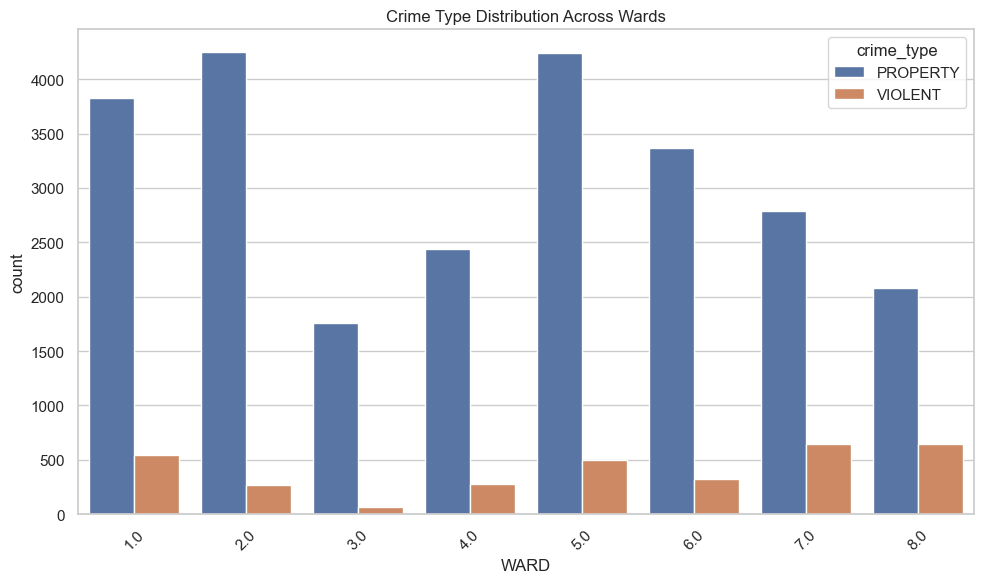

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

#  Grouping by ward and crime type
ward_crime = cc_final.groupby(['WARD', 'crime_type']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=ward_crime, x='WARD', y='count', hue='crime_type')
plt.title('Crime Type Distribution Across Wards')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The distribution of crime across wards shows a clear pattern: Wards 1, 2, and 5 experience the highest number of crimes, predominantly property-related, while Wards 7 and 8 show a relatively higher proportion of violent crimes, compared to others. Conversely, Wards 3 and 4 report significantly fewer crimes. we have follow up questions? 

In [96]:
# Grouping property and violent crimes by WARD
crime_by_ward = cc_final.groupby(['WARD', 'crime_type']).size().unstack(fill_value=0).reset_index()
crime_by_ward['total_crime'] = crime_by_ward['PROPERTY'] + crime_by_ward['VIOLENT']
# print(crime_by_ward.head())
# Select  poverty and unemployment rates per WARD
poverty_unemployment = cc_final[['WARD', 'poverty_rate_percent', 'unemployed_percent']].drop_duplicates()
# print(poverty_unemployment.head())
# Merge crime data with poverty and unemployment
merged_ward = pd.merge(crime_by_ward, poverty_unemployment, on='WARD', how='left')
# print(merged_ward.head())
# Correlation between poverty/unemployment and crime types
corr_poverty_property = merged_ward['PROPERTY'].corr(merged_ward['poverty_rate_percent'])
corr_poverty_violent = merged_ward['VIOLENT'].corr(merged_ward['poverty_rate_percent'])
corr_unemployment_property = merged_ward['PROPERTY'].corr(merged_ward['unemployed_percent'])
corr_unemployment_violent = merged_ward['VIOLENT'].corr(merged_ward['unemployed_percent'])
# print(f"Poverty vs Property Crime Correlation: {corr_poverty_property:.2f}")
# print(f"Poverty vs Violent Crime Correlation: {corr_poverty_violent:.2f}")
# print(f"Unemployment vs Property Crime Correlation: {corr_unemployment_property:.2f}")
# print(f"Unemployment vs Violent Crime Correlation: {corr_unemployment_violent:.2f}")


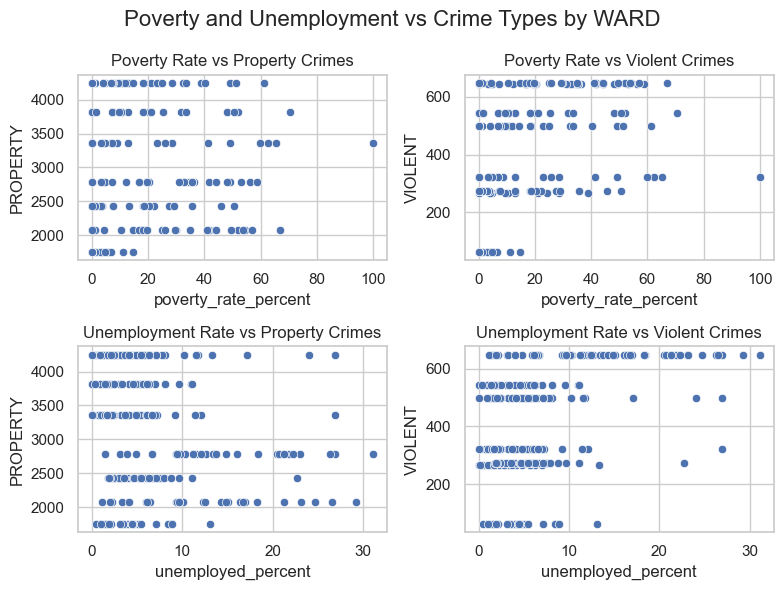

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create 2x2 plots
fig, axs = plt.subplots(2, 2, figsize=(8,6))
sns.scatterplot(data=merged_ward, x='poverty_rate_percent', y='PROPERTY', ax=axs[0,0])
axs[0,0].set_title('Poverty Rate vs Property Crimes')
sns.scatterplot(data=merged_ward, x='poverty_rate_percent', y='VIOLENT', ax=axs[0,1])
axs[0,1].set_title('Poverty Rate vs Violent Crimes')
sns.scatterplot(data=merged_ward, x='unemployed_percent', y='PROPERTY', ax=axs[1,0])
axs[1,0].set_title('Unemployment Rate vs Property Crimes')
sns.scatterplot(data=merged_ward, x='unemployed_percent', y='VIOLENT', ax=axs[1,1])
axs[1,1].set_title('Unemployment Rate vs Violent Crimes')
plt.suptitle('Poverty and Unemployment vs Crime Types by WARD', fontsize=16)
plt.tight_layout()
plt.show()


As poverty rate increases, violent crime clusters shift upwards slightly, especially after the 30–40% poverty mark.
As unemployment rises, both violent and property crimes show more spread but only violent crimes show a clear positive trend.
Areas with extreme poverty (>70%) and high unemployment show somewhat more violent activity, confirming that economic hardship amplifies violence more than theft.

In [101]:
# Which wards are most vulnerable based on poverty, unemployment, and education combined?
# (Later) Does housing instability (like rental rates, overcrowding) worsen vulnerability even further?

A vulnerability score is a single number we calculate to measure how economically and socially at-risk a neighborhood (WARD) is.It combines multiple risk factors — like poverty rate, unemployment rate, and low education level — into one score.
Higher the score, greater the vulnerability to social problems like higher crime rates, community instability.
we will be adding - 

poverty_rate_percent

unemployed_percent

less_than_hs_pct (percentage of people without a high school degree)

In [104]:
# Select needed columns: poverty, unemployment, and education (less than high school)
vulnerability_factors = cc_final[['WARD', 'poverty_rate_percent', 'unemployed_percent', 'less_than_hs_pct']].drop_duplicates()
# vulnerability_factors.head()

# Creating a 'vulnerability score' by simply adding the 3 risk factors
vulnerability_factors['vulnerability_score'] = (
    vulnerability_factors['poverty_rate_percent'] +
    vulnerability_factors['unemployed_percent'] +
    vulnerability_factors['less_than_hs_pct']
)
#vulnerability_factors.head()

# Sorting wards by the highest vulnerability score and even checking tail
vulnerable_wards = vulnerability_factors.sort_values('vulnerability_score', ascending=False)
#print(vulnerable_wards.head(3))


/var/folders/bd/h6f2p4l532x5vk1qlz9890r00000gn/T/ipykernel_24854/2247306635.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vulnerable_wards.head(5), x='WARD', y='vulnerability_score', palette='viridis')


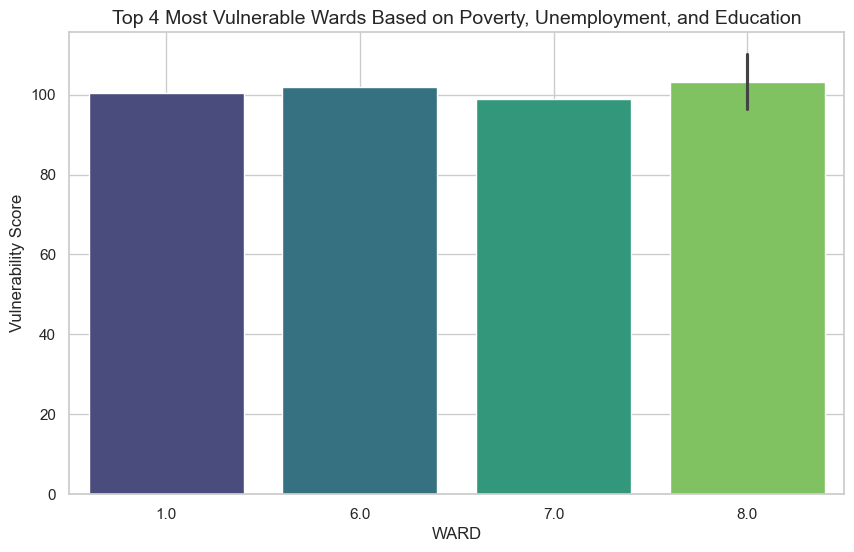

In [106]:








import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the top 5 most vulnerable wards
plt.figure(figsize=(10,6))
sns.barplot(data=vulnerable_wards.head(5), x='WARD', y='vulnerability_score', palette='viridis')
plt.title('Top 4 Most Vulnerable Wards Based on Poverty, Unemployment, and Education', fontsize=14)
plt.xlabel('WARD')
plt.ylabel('Vulnerability Score')
plt.grid(True)
plt.show()


In [108]:
# Top 5 most vulnerable wards
top_vulnerable_wards = vulnerable_wards['WARD'].head(5).tolist()

# Bottom 5 least vulnerable wards
bottom_vulnerable_wards = vulnerable_wards['WARD'].tail(5).tolist()

# print("Top Vulnerable Wards:", top_vulnerable_wards)
# print("Bottom Vulnerable Wards:", bottom_vulnerable_wards)

In [110]:
# Crimes in top vulnerable wards
crimes_top = cc_final[cc_final['WARD'].isin(top_vulnerable_wards)]
# Crimes in bottom vulnerable wards
crimes_bottom = cc_final[cc_final['WARD'].isin(bottom_vulnerable_wards)]
# Crime counts for top vulnerable wards
top_counts = crimes_top['crime_type'].value_counts().reset_index()
top_counts.columns = ['crime_type', 'count_in_top']
# Crime counts for bottom vulnerable wards
bottom_counts = crimes_bottom['crime_type'].value_counts().reset_index()
bottom_counts.columns = ['crime_type', 'count_in_bottom']
# Merge for comparison
crime_comparison = pd.merge(top_counts, bottom_counts, on='crime_type', how='outer').fillna(0)
# print(crime_comparison)

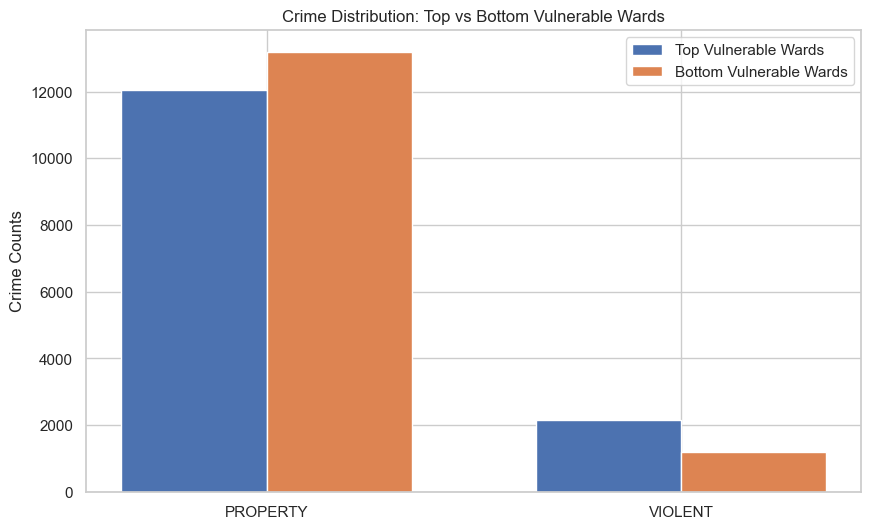

In [112]:
import numpy as np
x = np.arange(len(crime_comparison['crime_type']))  # the label locations
width = 0.35  # width of bars
fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, crime_comparison['count_in_top'], width, label='Top Vulnerable Wards')
rects2 = ax.bar(x + width/2, crime_comparison['count_in_bottom'], width, label='Bottom Vulnerable Wards')
# Add labels, title and legend
ax.set_ylabel('Crime Counts')
ax.set_title('Crime Distribution: Top vs Bottom Vulnerable Wards')
ax.set_xticks(x)
ax.set_xticklabels(crime_comparison['crime_type'])
ax.legend()
plt.grid(True)
plt.show()

Property Crimes are similar between top and bottom vulnerable wards (12,059 vs 13,193), with slightly more property crimes in low vulnerability wards. Violent Crimes are much higher in top vulnerable wards (2,157) compared to bottom wards (1,196). That's almost 80% more violent crimes in high-vulnerability wards. Property crimes seem widespread, not heavily dependent on socioeconomic vulnerability — they happen across all wards, even in economically better areas. However, violent crimes (like assaults, robberies with weapon, etc.) are much more concentrated in high vulnerability wards. Higher poverty, unemployment, and low education appear to amplify violent crime, even if they don't significantly increase property crimes.

#
---

---
# Housing Data

In [117]:
# housing variables
housing_vars = ['WARD', 'detached_ratio', 'large_multiunit_ratio', 'mobile_or_other_ratio',
                'homeownership_rate', 'rental_rate', 'vacancy_rate',
                'rent_cost_burden', 'mortgage_cost_burden', 'housing_value_category',
                'overcrowding_rate', 'residential_mobility_rate']

housing_data = cc_final[housing_vars].drop_duplicates()

#housing_data.head()

In [119]:
# Here we focus on housing and crime features
housing_vars = ['WARD', 'detached_ratio', 'large_multiunit_ratio', 'mobile_or_other_ratio',
                'homeownership_rate', 'rental_rate', 'vacancy_rate', 'residential_mobility_rate',
                'rent_cost_burden', 'mortgage_cost_burden', 'housing_value_category', 'overcrowding_rate']

# Take distinct housing values per WARD
housing_data = cc_final[housing_vars].drop_duplicates()

# Crime counts are grouped by WARD
crime_counts = cc_final.groupby('WARD')['crime_type'].value_counts().unstack(fill_value=0).reset_index()
# Merge the housing data with crime data
housing_crime = pd.merge(housing_data, crime_counts, on='WARD', how='left')
# housing_crime.head()

# Select only numeric columns first
numeric_cols = ['homeownership_rate', 'rental_rate', 'vacancy_rate', 'residential_mobility_rate',
                'overcrowding_rate', 'detached_ratio', 'large_multiunit_ratio', 'mobile_or_other_ratio',
                'rent_cost_burden', 'mortgage_cost_burden', 'VIOLENT', 'PROPERTY']

# Now calculate correlation only on numeric part
correlation_matrix = housing_crime[numeric_cols].corr()[['VIOLENT', 'PROPERTY']].loc[
    ['homeownership_rate', 'rental_rate', 'vacancy_rate', 'residential_mobility_rate',
     'overcrowding_rate', 'detached_ratio', 'large_multiunit_ratio', 'mobile_or_other_ratio',
     'rent_cost_burden', 'mortgage_cost_burden']
]

correlation_matrix

,VIOLENT,PROPERTY
homeownership_rate,-0.257289,-0.125411
rental_rate,0.257289,0.125411
vacancy_rate,0.028593,0.101912
residential_mobility_rate,-0.174428,0.314980
overcrowding_rate,0.158095,-0.019905
detached_ratio,-0.230928,-0.329340
large_multiunit_ratio,-0.217565,0.210249
mobile_or_other_ratio,0.023345,0.013702
rent_cost_burden,0.098441,-0.076368
mortgage_cost_burden,-0.367802,0.275743


Analysis - Higher rental rates are associated with increased violent and property crimes.

Lower homeownership rates correlate with higher overall crime, suggesting that stable, long-term ownership contributes to safer neighborhoods. Greater overcrowding shows a positive association with violent crime, indicating that stressful living environments can escalate tensions leading to violence. Higher residential mobility correlates with higher property crimes, as transient populations often weaken community trust and oversight. Detached housing prevalence is linked to lower crime rates, while wards with more large multi-unit buildings show slight increases in property-related offenses. vacancy rates and rent burdens have moderate but noticeable effects, particularly raising opportunities for property crimes.

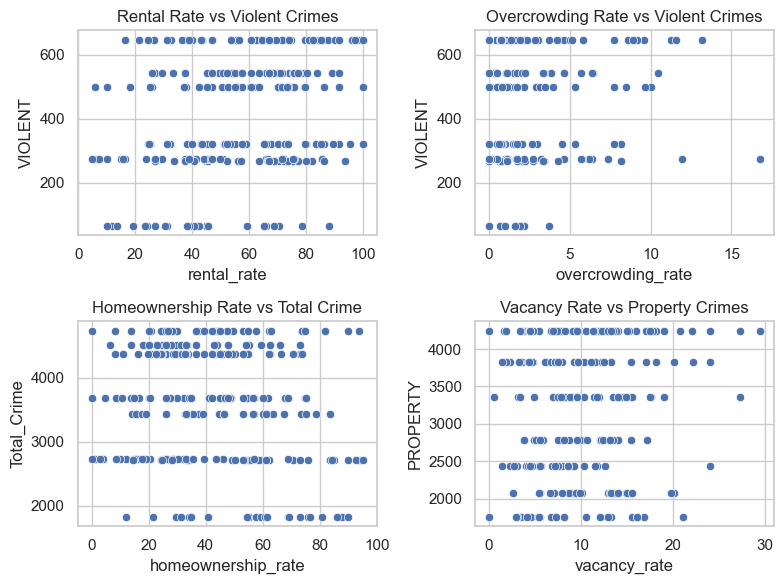

In [122]:
# Scatterplots for strongest features

fig, axs = plt.subplots(2, 2, figsize=(8,6))

# Rental Rate vs Violent Crime
sns.scatterplot(data=housing_crime, x='rental_rate', y='VIOLENT', ax=axs[0,0])
axs[0,0].set_title('Rental Rate vs Violent Crimes')

# Overcrowding vs Violent Crime
sns.scatterplot(data=housing_crime, x='overcrowding_rate', y='VIOLENT', ax=axs[0,1])
axs[0,1].set_title('Overcrowding Rate vs Violent Crimes')

# Homeownership vs Total Crimes
housing_crime['Total_Crime'] = housing_crime['VIOLENT'] + housing_crime['PROPERTY']
sns.scatterplot(data=housing_crime, x='homeownership_rate', y='Total_Crime', ax=axs[1,0])
axs[1,0].set_title('Homeownership Rate vs Total Crime')

# Vacancy Rate vs Property Crimes
sns.scatterplot(data=housing_crime, x='vacancy_rate', y='PROPERTY', ax=axs[1,1])
axs[1,1].set_title('Vacancy Rate vs Property Crimes')

plt.tight_layout()
plt.show()

In [4]:
cc_final.columns.tolist()

NameError: name 'cc_final' is not defined

---
# Export for Team Data Science Use 

In [128]:
### Final Export for Team Use

# Replace `final_df` with the actual DataFrame you intend to export
import os
try:
    export_path = os.path.join("Data Out", "team5_enriched_dataset.csv")
    cc_final.to_csv(export_path, index=False)
    print(f"Exported final dataset to: {export_path}")
except NameError:
    print("'final_df' is not defined. Please define your final dataframe before exporting.")

    

Exported final dataset to: Data Out/team5_enriched_dataset.csv


---
# Import Dataset for Team Use

The file `Data Out/enriched_dataset_for_analysis.csv` is the **final cleaned and enriched dataset** generated from this notebook. It is intended for all downstream data science, machine learning, and visualization work.

#### Contents
This dataset includes:

- Core crime incident attributes (`OFFENSE`, `SHIFT`, `REPORT_DAT`, etc.)
- Geospatial fields (`LATITUDE`, `LONGITUDE`, `WARD`, `CENSUS_TRACT`)
- Enriched socioeconomic indicators (e.g., education, mobility, household structure)
- **Excludes** population density and any data derived from SP05 due to ethical concerns

#### Usage
You can import this dataset by running the cell below. There is no need to run all the cells above unless something needs to change. 

If you change anything above PLEASE CLEAR IT WITH THE TEAM IN WRITING!  

In [1]:
import pandas as pd
import os

# Join folder and filename
rich_data_read = os.path.join("Data Out", "team5_enriched_dataset.csv")

# Load the CSV
rich_data = pd.read_csv(rich_data_read)
pd.set_option('display.max_columns',None)

rich_data.head(2)

,X,Y,CCN,REPORT_DAT,SHIFT,METHOD,OFFENSE,BLOCK,XBLOCK,YBLOCK,WARD,ANC,DISTRICT,PSA,NEIGHBORHOOD_CLUSTER,BLOCK_GROUP,CENSUS_TRACT,VOTING_PRECINCT,LATITUDE,LONGITUDE,START_DATE,END_DATE,single_parent_rate_percent,residential_mobility_rate,less_than_hs_pct,bachelors_or_higher_pct,percent born in same state,percent foreign born,avg_household_size,poverty_rate_percent,employed_percent,unemployed_percent,Median_Household_Income,with_health_insurance,without_health_insurance,housing_age_category,detached_ratio,large_multiunit_ratio,mobile_or_other_ratio,homeownership_rate,rental_rate,vacancy_rate,rent_cost_burden,mortgage_cost_burden,housing_value_category,overcrowding_rate,percent_born_in_different_state,report_month,CPIAUCSL,crime_type
0,399622.2700,134352.62,24093246,2024/06/19 14:52:56+00,DAY,OTHERS,THEFT/OTHER,1100 - 1199 BLOCK OF NEW JERSEY AVENUE SE,399622.270000,134352.620000,8.0,8F,1.0,106.0,Cluster 27,007203 1,7203.0,Precinct 131,38.877004,-77.004353,2024-06-19 14:50:00+00:00,2024-06-19 14:52:00+00:00,6.875000,23.812405,2.013177,78.111274,76.701967,7.443268,1.69,0.0,97.816234,2.183766,166316.0,100.000000,0.000000,New,0.010638,0.806738,0.000000,20.312500,79.687500,14.893617,0.60,25.75,High,0.000000,23.298033,2024-06,313.131,PROPERTY
1,398579.1351,134828.40,24131497,2024/08/27 01:13:37+00,EVENING,OTHERS,THEFT F/AUTO,300 - 399 BLOCK OF G STREET SW,398579.135069,134828.399995,6.0,6D,1.0,103.0,Cluster 9,010500 2,10500.0,Precinct 128,38.881289,-77.016376,2024-08-26 18:51:00+00:00,2024-08-26 20:14:00+00:00,2.971138,28.841112,7.398040,69.269681,76.977107,11.940687,1.63,65.3,94.849637,5.150363,107414.0,96.315652,3.684348,Old,0.000000,0.814570,0.023374,32.512733,67.487267,8.219712,0.81,19.90,Low,2.037351,23.022893,2024-08,314.131,PROPERTY


---
Will
# Random Forest Classifier

## Isolating the socioeconomic features

In [136]:
features_to_use = [
    'single_parent_rate_percent',
    'residential_mobility_rate',
    'less_than_hs_pct',
    'bachelors_or_higher_pct',
    'percent born in same state',
    'percent_born_in_different_state',
    'avg_household_size',
    'poverty_rate_percent',
    'employed_percent',
    'unemployed_percent',
    'Median_Household_Income',
    'with_health_insurance',
    'without_health_insurance',
    'detached_ratio',
    'large_multiunit_ratio',
    'mobile_or_other_ratio',
    'homeownership_rate',
    'rental_rate',
    'vacancy_rate',
    'rent_cost_burden',
    'mortgage_cost_burden',
    'overcrowding_rate',
    'CPIAUCSL'
]

In [138]:
cc_final = rich_data.copy()

In [140]:
#dividing and grouping offenses into violent and property
violent_crimes = [ 'ROBBERY',  'ASSAULT W/DANGEROUS WEAPON', 'HOMICIDE','SEX ABUSE', 'ARSON']
property_crimes = [ 'THEFT/OTHER','THEFT F/AUTO','MOTOR VEHICLE THEFT','BURGLARY']
cc_final['crime_type'] = cc_final['OFFENSE'].apply(
    lambda x: 'VIOLENT' if x in violent_crimes else (
        'PROPERTY' if x in property_crimes else 'OTHER'
    )
)
print(cc_final['crime_type'].value_counts())



crime_type
PROPERTY    24741
VIOLENT      3262
Name: count, dtype: int64


## Random Forest Classifier: No class balancing

**What is Random Forest?**
Random Forest is an ensemble machine learning algorithm that builds multiple decision trees during training and outputs the class that is the mode (majority vote) of the individual trees. It’s robust, handles both classification and regression, and automatically captures complex feature interactions and non-linear relationships.

**Why Should We Use Random Forest?**

1 - Handles high-dimensional data well – no need for feature selection or scaling.

2 - Robust to overfitting – due to averaging across multiple trees.

3 - Good performance with imbalanced data – supports class weighting and can be paired with SMOTE.

4 - Captures non-linear relationships – unlike logistic regression or linear models.

5 - Interpretable – provides feature importance scores for understanding drivers of predictions.

**Why Should We Not Use Random Forest?**

1 - Slower for large datasets – especially during training or hyperparameter tuning.

2 - Less interpretable than single decision trees – although better than black-box models like neural networks.

3 - Memory-intensive – storing many trees can consume more memory.

4 - Not ideal for real-time predictions – due to computational overhead if many trees are used.



              precision    recall  f1-score   support

    PROPERTY       0.89      0.99      0.94      4949
     VIOLENT       0.35      0.04      0.07       652

    accuracy                           0.88      5601
   macro avg       0.62      0.51      0.50      5601
weighted avg       0.82      0.88      0.83      5601



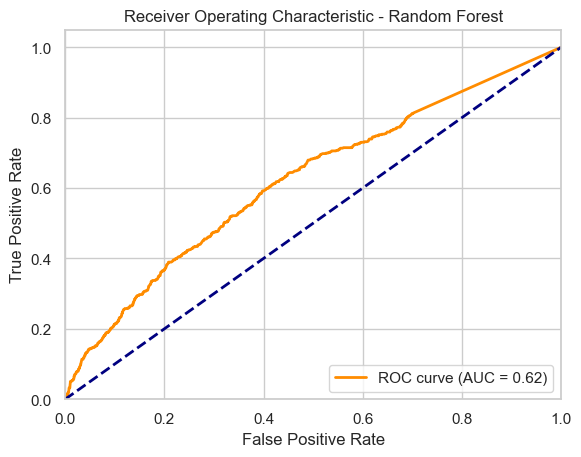

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# Create feature matrix X and target vector y
X = rich_data[features_to_use]
y = rich_data.iloc[:,-1]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

#Plotting AUROC to help evaluation
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label='VIOLENT')
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

***In this model no we do not mitigate class imbalance, in the next models we do that to see the difference***
 currently here we are running random forest classifier without using any class balancing methods

## Random Forest Classifier:  Class balancing

***NOW WE ARE GOING TO USE CLASSS WEIGHTS***

What Are Class Weights?
Class weights are a technique used in classification models to give more importance to underrepresented classes. During model training, misclassifications of the minority class are penalized more heavily than those of the majority class. This encourages the model to pay more attention to the minority class.


***Why Are We Using Class Weights?***

1 - Handles imbalance without changing data – no need to duplicate or synthesize samples.

2 - Works well with many algorithms – including Logistic Regression, SVM, Random Forest.

3 - Simple to implement – just one line of code.

4 - Avoids overfitting – doesn’t create synthetic points like SMOTE might.

***Why Should We Not Use Class Weights?***

1 - Not always effective with extreme imbalance – especially when the minority class is too rare.

2 - Some models ignore weights – not all implementations respect them equally.

3 - May increase false positives – trying to improve recall may reduce precision.

              precision    recall  f1-score   support

    PROPERTY       0.91      0.74      0.82      4949
     VIOLENT       0.18      0.42      0.25       652

    accuracy                           0.71      5601
   macro avg       0.54      0.58      0.53      5601
weighted avg       0.82      0.71      0.75      5601



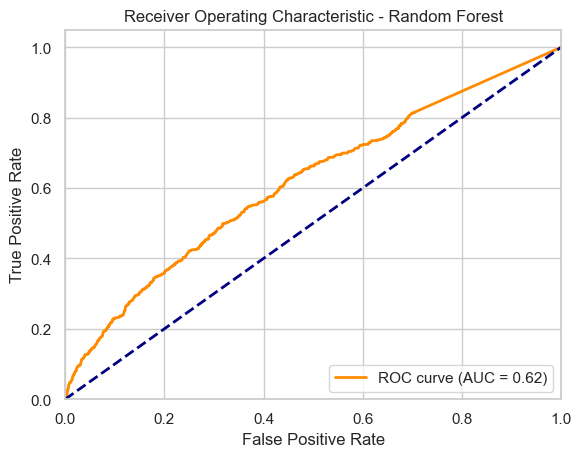

In [145]:
# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, class_weight = 'balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

#Plotting AUROC to help evaluation
y_probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs, pos_label='VIOLENT')
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Conclusion**:  
The class balancing significantly improved the recall for the VIOLENT class (0.04 to 0.42) at the cost of precision. This makes sense as this model is far more likely to predict the VIOLENT class than without class balancing. The f1-score for the VIOLENT class was also much better in this model without losing AUROC.

## GridSearchCV RandomForestClassifier without SMOTE or class_weight

In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Defining feature columns
features_to_use = [
    'single_parent_rate_percent',
    'residential_mobility_rate',
    'less_than_hs_pct',
    'bachelors_or_higher_pct',
    'percent born in same state',
    'percent_born_in_different_state',
    'avg_household_size',
    'poverty_rate_percent',
    'employed_percent',
    'unemployed_percent',
    'Median_Household_Income',
    'with_health_insurance',
    'without_health_insurance',
    'detached_ratio',
    'large_multiunit_ratio',
    'mobile_or_other_ratio',
    'homeownership_rate',
    'rental_rate',
    'vacancy_rate',
    'rent_cost_burden',
    'mortgage_cost_burden',
    'overcrowding_rate',
    'CPIAUCSL'
]

#  Preparing data
X = cc_final[features_to_use].dropna()
y = cc_final.loc[X.index, 'crime_type'].map({'PROPERTY': 0, 'VIOLENT': 1})

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# GridSearchCV without SMOTE or class_weight
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train, y_train)

#  Best model
best_model = grid.best_estimator_

#  Train evaluation
y_train_pred = best_model.predict(X_train)
print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

#  Test evaluation
y_test_pred = best_model.predict(X_test)
print("\n--- Testing Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



--- Training Set Evaluation ---
Accuracy: 0.8889909192939496
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     17319
           1       0.67      0.09      0.17      2283

    accuracy                           0.89     19602
   macro avg       0.78      0.54      0.55     19602
weighted avg       0.87      0.89      0.85     19602

Confusion Matrix:
 [[17211   108]
 [ 2068   215]]

--- Testing Set Evaluation ---
Accuracy: 0.8734674443518629
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93      7422
           1       0.22      0.03      0.06       979

    accuracy                           0.87      8401
   macro avg       0.55      0.51      0.49      8401
weighted avg       0.81      0.87      0.83      8401

Confusion Matrix:
 [[7306  116]
 [ 947   32]]


The baseline Random Forest Classifier, tuned with GridSearchCV but without class balancing, achieved a training accuracy of 88.9% and a testing accuracy of 87.3%. While the model performed exceptionally well for property crimes, with high precision and recall, it struggled significantly with violent crimes. On the test set, recall for violent crimes was only 3%, with an F1-score of 0.06, indicating the model failed to identify the vast majority of such incidents. Despite high overall accuracy, the model’s performance is heavily skewed toward the majority class

The code below computes and plots the ROC curve and AUC for a Random Forest model to evaluate how well it distinguishes violent from property crimes

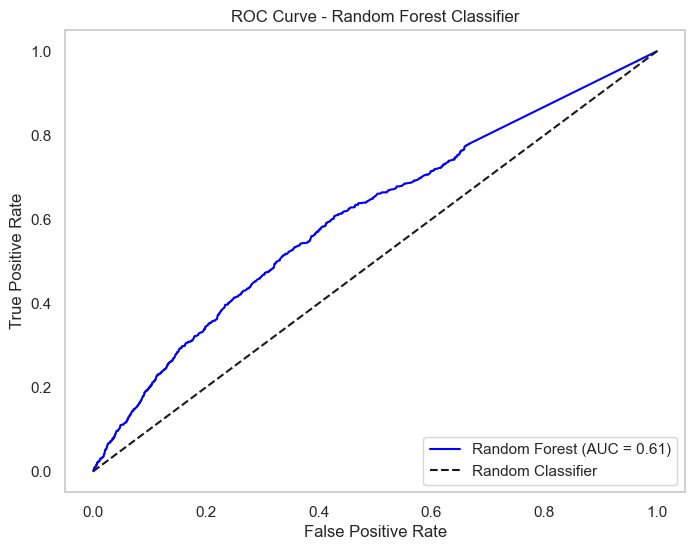

In [154]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for class 1 (VIOLENT)
y_test_probs = best_model.predict_proba(X_test)[:, 1]  # Assuming best_model is RandomForestClassifier

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs, pos_label=1)
auc_score = roc_auc_score(y_test, y_test_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid()
plt.show()


This ROC curve evaluates the performance of a Random Forest classifier distinguishing between property and violent crimes. The AUC (Area Under the Curve) is 0.61, indicating the model performs only slightly better than random guessing (AUC = 0.5). A well-performing model typically has an AUC closer to 1.0. The curve’s proximity to the diagonal suggests the model struggles to effectively differentiate between the two classes.

## GridSearchCV RandomForestClassifier with SMOTE

***Now we perform random forest classifier by balancing class by using SMOTE technique and then in next upcoming models we are gonna use use class weights***

***What is SMOTE?***

SMOTE (Synthetic Minority Oversampling Technique) is widely used in machine learning to address the issue of class imbalance. In our crime classification, the dataset contains  more property crimes than violent crimes, SMOTE can be a valuable tool to improve our model performance, particularly for underrepresented crime categories.


***Why You Should Use SMOTE***
1) Class Imbalance Exists -  When the  dataset has many more examples of one class (e.g., property crimes) than another (e.g., violent crimes), models tend to favor the majority class. SMOTE helps address this.

2) Poor Recall or F1-Score for Minority Class - If our model is achieving high accuracy but low recall or F1 for the minority class, it means it is failing to detect that class well. SMOTE can help improve this.

3) So if we Want our Model to learn more about the Minority class by synthetically increasing the presence of the minority class in the training data, SMOTE helps us the model better learn its patterns.

4) SMOTE can reduce the bias introduced by an imbalanced training set and help the model generalize better on underrepresented classes.

***Why You Should Not Use SMOTE***

1) When the Minority Class is Noisy - If the minority class contains outliers or mislabeled examples, SMOTE may amplify those errors by generating synthetic data based on them.

2) High Risk of Overfitting - By adding synthetic data without adding more real data, SMOTE can lead to overfitting, especially if applied on a small dataset.

3) Not Useful for Test Data -  SMOTE should only be applied to the training data. Using it on the test set invalidates the evaluation because the synthetic data doesn't exist in the real world.

In [161]:
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#  Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#  Random Forest with GridSearchCV on SMOTE data
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train_smote, y_train_smote)

#  Evaluate best model
best_model = grid.best_estimator_

# Training evaluation
y_train_pred = best_model.predict(X_train_smote)
print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(y_train_smote, y_train_pred))
print("Classification Report:\n", classification_report(y_train_smote, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train_smote, y_train_pred))

# Testing evaluation
y_test_pred = best_model.predict(X_test)
print("\n--- Testing Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- Training Set Evaluation ---
Accuracy: 0.8610485593856458
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86     17319
           1       0.86      0.86      0.86     17319

    accuracy                           0.86     34638
   macro avg       0.86      0.86      0.86     34638
weighted avg       0.86      0.86      0.86     34638

Confusion Matrix:
 [[14853  2466]
 [ 2347 14972]]

--- Testing Set Evaluation ---
Accuracy: 0.7785977859778598
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87      7422
           1       0.19      0.27      0.22       979

    accuracy                           0.78      8401
   macro avg       0.54      0.56      0.55      8401
weighted avg       0.82      0.78      0.80      8401

Confusion Matrix:
 [[6275 1147]
 [ 713  266]]


The Random Forest Classifier with SMOTE and GridSearchCV achieved strong performance on the balanced training set, with 86% accuracy and equal precision, recall, and F1-scores for both classes. On the test set, the model reached 77.9% accuracy. It maintained high performance for property crimes (class 0), with an F1-score of 0.87. For violent crimes (class 1), recall was 27% and precision 19%, resulting in an F1-score of 0.22. This indicates the model was able to detect over a quarter of violent incidents, although many predictions were false positives

The code below plots the ROC curve for a Random Forest model trained with SMOTE by calculating prediction probabilities, computing AUC, and visualizing classifier performance on test data.


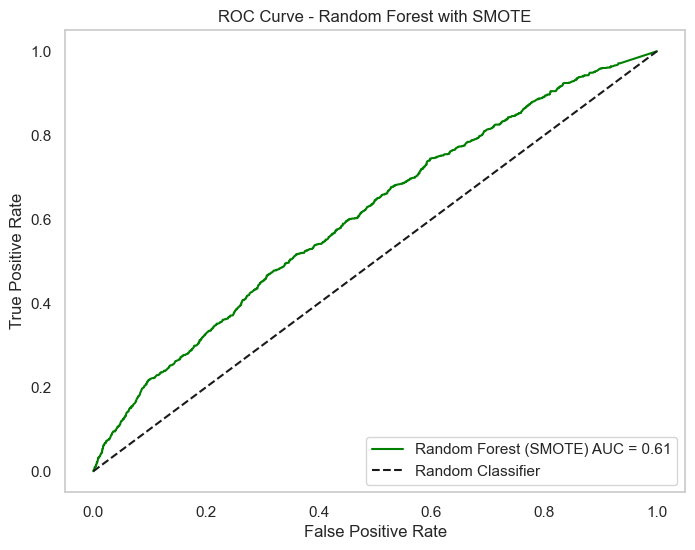

In [165]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for class 1 (VIOLENT) on test data
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs, pos_label=1)
auc_score = roc_auc_score(y_test, y_test_probs)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (SMOTE) AUC = {auc_score:.2f}', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest with SMOTE')
plt.legend(loc='lower right')
plt.grid()
plt.show()


This ROC curve illustrates the performance of a Random Forest classifier trained using SMOTE to address class imbalance in crime type prediction. The curve represents the model’s ability to differentiate between property and violent crimes based on various threshold values. The Area Under the Curve (AUC) is 0.61, which is only slightly better than random guessing (AUC = 0.5). While SMOTE successfully balances the training data, it may introduce synthetic noise that does not reflect real-world distributions, possibly explaining the modest improvement in AUC. The green line, representing the model’s performance, stays close to the diagonal, indicating weak class separation. Although recall for the minority class might improve after SMOTE, the overall discriminative power remains limited. This suggests that while SMOTE helps reduce bias in class predictions, it may not significantly enhance model robustness

## GridSearchCV RandomForestClassifier with Class_weight

In [170]:
#USING CLASS WEIGHTS
#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#  Train Random Forest with class_weight='balanced'
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1
)
grid.fit(X_train, y_train)

#  Best model
best_model = grid.best_estimator_

# Train evaluation
y_train_pred = best_model.predict(X_train)
print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

# Test evaluation
y_test_pred = best_model.predict(X_test)
print("\n--- Testing Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



--- Training Set Evaluation ---
Accuracy: 0.7278849097030915
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.74      0.83     17319
           1       0.24      0.64      0.35      2283

    accuracy                           0.73     19602
   macro avg       0.59      0.69      0.59     19602
weighted avg       0.86      0.73      0.77     19602

Confusion Matrix:
 [[12806  4513]
 [  821  1462]]

--- Testing Set Evaluation ---
Accuracy: 0.7061064159028687
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.82      7422
           1       0.20      0.49      0.28       979

    accuracy                           0.71      8401
   macro avg       0.56      0.61      0.55      8401
weighted avg       0.83      0.71      0.75      8401

Confusion Matrix:
 [[5452 1970]
 [ 499  480]]


The Random Forest Classifier with class weighting achieved a training accuracy of 72.7% and a testing accuracy of 70.6%. In the training set, it attained a recall of 64% and an F1-score of 0.35 for violent crimes. On the test set, recall for violent crimes was 49%, with an F1-score of 0.28. Precision for violent crimes was 24% in training and 20% in testing. The model effectively identified a substantial portion of violent crime instances, with overall macro-averaged F1-scores of 0.59 (train) and 0.55 (test), demonstrating balanced yet moderate classification capability.

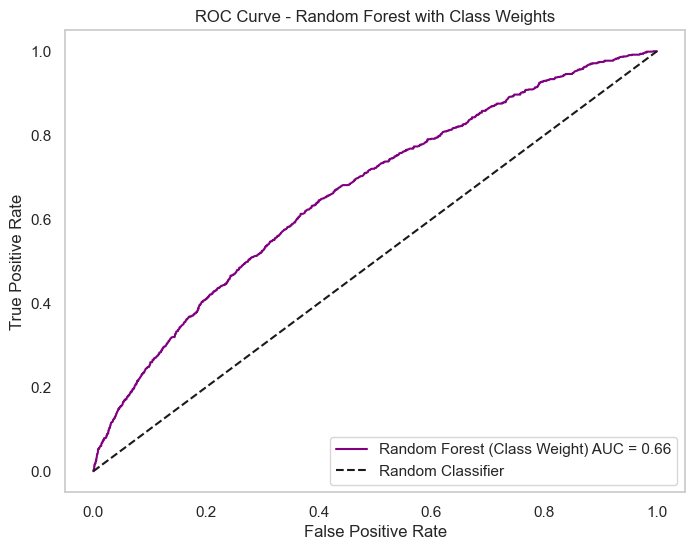

In [172]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (VIOLENT)
y_test_probs = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs, pos_label=1)
auc_score = roc_auc_score(y_test, y_test_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (Class Weight) AUC = {auc_score:.2f}', color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest with Class Weights')
plt.legend(loc='lower right')
plt.grid()
plt.show()


                                             ***CONCLUSION REPORT***

**Three Random Forest** models were evaluated to classify crimes as property or violent, each using a different strategy to address class imbalance: baseline (no balancing), SMOTE, and class weights. The baseline model achieved the highest accuracy (87.3%) but failed to detect violent crimes effectively, with only 3% recall and an F1-score of 0.06. The SMOTE-based model showed improved recall (27%) and an F1-score of 0.22, indicating better detection but at the cost of accuracy. The model using class weights demonstrated the most balanced performance, achieving 49% recall and the highest F1-score (0.28) for violent crimes, while maintaining a reasonable accuracy of 70.6%. These results highlight that high accuracy alone is not a reliable metric in imbalanced classification problems. For safety-critical applications like crime detection, the class-weighted model offers the most effective balance between fairness and performance

***here we are plotting decision boundary regions for random forest***

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


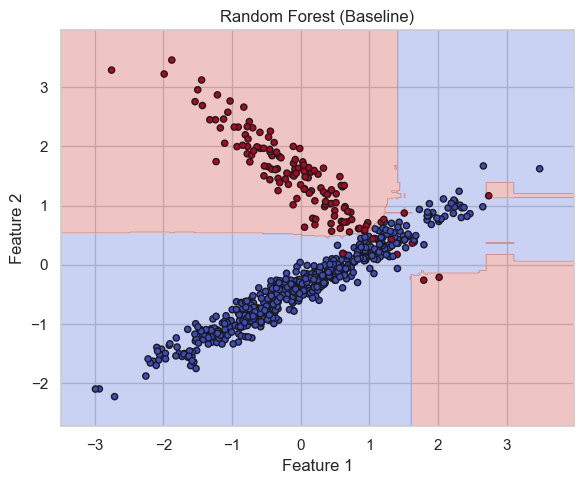

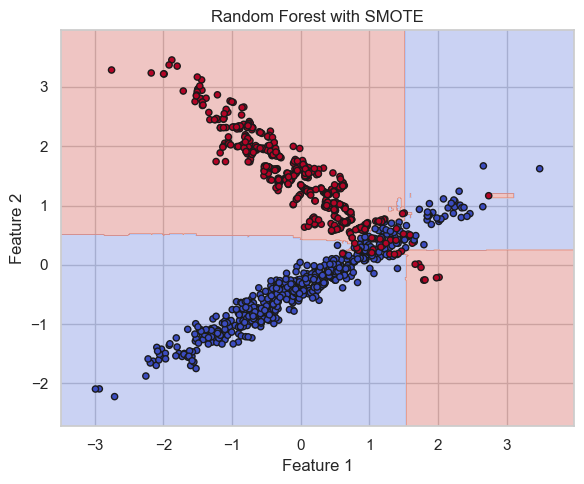

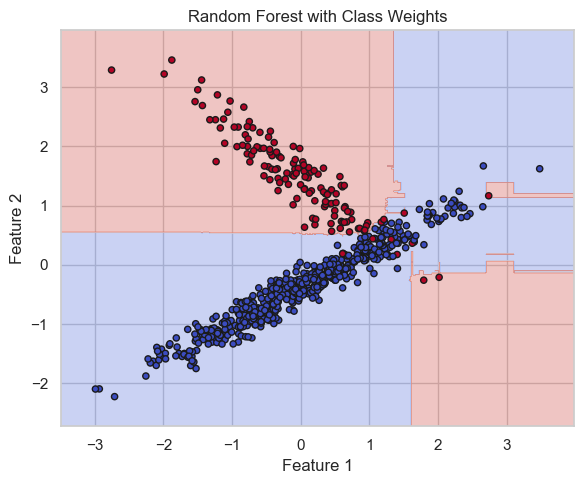

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Step 1: Generate synthetic imbalanced dataset (2 features for plotting)
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.8, 0.2],
                           class_sep=1.0, random_state=42)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Step 3: Scale features (optional for RF, but for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4a: Baseline Random Forest
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train_scaled, y_train)

# Step 4b: SMOTE Random Forest
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
smote_rf = RandomForestClassifier(random_state=42)
smote_rf.fit(X_train_smote, y_train_smote)

# Step 4c: Class Weighted Random Forest
weight_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
weight_rf.fit(X_train_scaled, y_train)

# Step 5: Plotting function
def plot_rf_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm, s=20)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Step 6: Visualizations
plot_rf_decision_boundary(baseline_rf, X_train_scaled, y_train, "Random Forest (Baseline)")
plot_rf_decision_boundary(smote_rf, X_train_smote, y_train_smote, "Random Forest with SMOTE")
plot_rf_decision_boundary(weight_rf, X_train_scaled, y_train, "Random Forest with Class Weights")


**Conclusion**:  
We can see that the Baseline and Class Weight graphs are very similar, with only a few differences between them. But as we could expect, the graph for SMOTE is distinct in that it has many more synthetic Violent points. The effect of this can also been seen in the graph as there are fewer sharp edges around the boundary than the other two graphs.

---
Rithesh

# XGBoost

###
***Now we are going to implement xgboost classifier through baseline, smote and class weight***

The three decision boundary plots showcase how Logistic Regression performs under three different strategies for handling class imbalance: baseline (no adjustment), SMOTE, and class weights.

Baseline Logistic Regression (First Image):
The decision boundary is heavily skewed in favor of the majority class. The minority class (red) is poorly represented, and many of its points fall on the wrong side of the boundary. This occurs because the model learns from the imbalanced training data without any correction.

Logistic Regression with SMOTE (Second Image):
Here, SMOTE oversampling creates synthetic examples for the minority class, leading to a more balanced training set. The decision boundary shifts noticeably, covering more of the red class. This helps the classifier generalize better, especially for the minority class, although it might also introduce some noisy boundaries due to synthetic data.

Logistic Regression with Class Weights (Third Image):
Class weights penalize misclassification of the minority class more strongly. The resulting boundary is more balanced than the baseline, though less aggressive than SMOTE. It attempts to retain the natural data distribution while still improving recall for the minority class.

Summary:
SMOTE expands the red region the most, class weights provide a middle ground, and the baseline model underrepresents the minority class. Each strategy balances bias-variance differently.

***Now we are going to implement xgboost classifier through baseline, smote and class weight***

### What is XGBoost?

**XGBoost** (Extreme Gradient Boosting) is a powerful, scalable machine learning algorithm based on **gradient boosting**. It builds decision trees sequentially, where each new tree attempts to correct the errors made by the previous one. It’s known for its speed, regularization, and high performance on structured (tabular) data.

---

###  Why Should We Use XGBoost?

1. **High Accuracy**: XGBoost is consistently one of the top-performing algorithms in competitions and real-world applications.
2. **Handles Missing Data**: It can automatically handle missing values without preprocessing.
3. **Built-in Regularization**: Prevents overfitting through `L1` and `L2` penalties.
4. **Supports Imbalanced Learning**: Parameters like `scale_pos_weight` make it easier to handle class imbalance.
5. **Speed & Efficiency**: Highly optimized for performance with parallel processing and cache-awareness.
6. **Feature Importance**: Offers easy extraction of feature importances for interpretability.
7. **Flexible**: Works for regression, classification, ranking, and even survival analysis.

---

###  Why Should We Not Use XGBoost?

1. **Complexity**: It’s a black-box model; hard to interpret compared to linear models.
2. **Training Time**: Slower than simpler models (e.g., logistic regression), especially on very large datasets.
3. **Memory Usage**: Can be memory-intensive with many trees or large feature spaces.
4. **Hyperparameter Tuning**: Requires careful tuning of many parameters for optimal performance.
5. **Overfitting Risk**: Especially without proper regularization or when used on small datasets.

---



## XGBoost

In [186]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from xgboost import XGBClassifier

The code below splits data into training and testing sets, scales the features, and uses GridSearchCV to tune an XGBoost classifier on the training data. It optimizes hyperparameters (n_estimators, max_depth, learning_rate) using 3-fold cross-validation and the F

In [203]:
X = cc_final[features_to_use].dropna()
y = cc_final.loc[X.index, 'crime_type'].map({'PROPERTY': 0, 'VIOLENT': 1})
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 4. Standardize features (optional for XGBoost, used here for consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Define XGBoost model and GridSearchCV
xgb_model = XGBClassifier(
    verbosity=0,  # replaces deprecated use_label_encoder
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# 6. Fit model
grid.fit(X_train_scaled, y_train)
best_model = grid.best_estimator_

# 7. Training evaluation
y_train_pred = best_model.predict(X_train_scaled)
print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

# 8. Testing evaluation
y_test_pred = best_model.predict(X_test_scaled)
print("\n--- Testing Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


--- Training Set Evaluation ---
Accuracy: 0.8875624936230997
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     17319
           1       0.70      0.06      0.11      2283

    accuracy                           0.89     19602
   macro avg       0.79      0.53      0.53     19602
weighted avg       0.87      0.89      0.84     19602

Confusion Matrix:
 [[17258    61]
 [ 2143   140]]

--- Testing Set Evaluation ---
Accuracy: 0.8803713843590049
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      7422
           1       0.33      0.03      0.05       979

    accuracy                           0.88      8401
   macro avg       0.61      0.51      0.49      8401
weighted avg       0.82      0.88      0.83      8401

Confusion Matrix:
 [[7371   51]
 [ 954   25]]


The baseline XGBoost classifier with GridSearchCV achieved high accuracy: 88.8% on the training set and 88.0% on the test set. However, it performed poorly on identifying violent crimes. In the training data, recall for violent crimes was only 6%, and on the test data, just 3%, indicating that most violent incidents were misclassified as property crimes. Although the model was highly accurate overall due to the dominance of property crimes, it demonstrated clear bias toward the majority class. The F1-score for violent crimes remained low (0.05–0.11), making this model ineffective for balanced crime detection without further handling of class imbalance.

The code below performs classification using XGBoost with SMOTE to handle class imbalance. It splits the dataset into training and testing sets, scales the features, and applies SMOTE to oversample the minority class (violent crimes) in the training data. It then performs hyperparameter tuning on the XGBoost classifier using GridSearchCV with F1-score as the evaluation metric

## XGBoost with SMOTE

In [208]:
from imblearn.over_sampling import SMOTE
#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#  Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Define XGBoost and hyperparameter grid
xgb_model = XGBClassifier(verbosity=0, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# Train model
grid.fit(X_train_smote, y_train_smote)
best_model = grid.best_estimator_

# Training evaluation
y_train_pred = best_model.predict(X_train_smote)
print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(y_train_smote, y_train_pred))
print("Classification Report:\n", classification_report(y_train_smote, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train_smote, y_train_pred))

# Testing evaluation
y_test_pred = best_model.predict(X_test_scaled)
print("\n--- Testing Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- Training Set Evaluation ---
Accuracy: 0.8490097580691726
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85     17319
           1       0.87      0.82      0.84     17319

    accuracy                           0.85     34638
   macro avg       0.85      0.85      0.85     34638
weighted avg       0.85      0.85      0.85     34638

Confusion Matrix:
 [[15258  2061]
 [ 3169 14150]]

--- Testing Set Evaluation ---
Accuracy: 0.8037138435900488
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      7422
           1       0.21      0.25      0.23       979

    accuracy                           0.80      8401
   macro avg       0.55      0.56      0.56      8401
weighted avg       0.82      0.80      0.81      8401

Confusion Matrix:
 [[6511  911]
 [ 738  241]]


The XGBoost model trained with SMOTE and optimized via GridSearchCV achieved a training accuracy of 84.9% and a testing accuracy of 80.4%. On the training set, it demonstrated balanced performance between the two classes, with nearly equal precision and recall for property and violent crimes. On the test set, the model correctly identified 25% of violent crimes, improving recall significantly compared to the baseline model. However, precision for violent crimes remained low at 21%, indicating some increase in false positives. Overall, the model shows a strong trade-off between general accuracy and minority class detection, making it more suitable for applications where capturing violent crimes is a priority.










## XGBoost with Weights

###
***The code below cales features, calculates class weights, tunes an XGBoost model using GridSearchCV, and evaluates its performance on training and testing data for imbalanced classification.**


In [213]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#  Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#  Compute class weight
# scale_pos_weight = (number of class 0 samples) / (number of class 1 samples)
from collections import Counter
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

# Define XGBoost and GridSearchCV
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    verbosity=0,
    eval_metric='logloss',
    random_state=42
)

param_grid = {
    'n_estimators': [100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# Train model
grid.fit(X_train_scaled, y_train)
best_model = grid.best_estimator_

# Training evaluation
y_train_pred = best_model.predict(X_train_scaled)
print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

# Testing evaluation
y_test_pred = best_model.predict(X_test_scaled)
print("\n--- Testing Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


--- Training Set Evaluation ---
Accuracy: 0.660238751147842
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.66      0.77     17319
           1       0.21      0.67      0.31      2283

    accuracy                           0.66     19602
   macro avg       0.57      0.66      0.54     19602
weighted avg       0.85      0.66      0.72     19602

Confusion Matrix:
 [[11420  5899]
 [  761  1522]]

--- Testing Set Evaluation ---
Accuracy: 0.6511129627425306
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.66      0.77      7422
           1       0.19      0.60      0.29       979

    accuracy                           0.65      8401
   macro avg       0.56      0.63      0.53      8401
weighted avg       0.84      0.65      0.71      8401

Confusion Matrix:
 [[4881 2541]
 [ 390  589]]


The XGBoost model trained using scale_pos_weight to handle class imbalance achieved a training accuracy of 66% and a testing accuracy of approximately 65%. The model demonstrated significant improvement in detecting violent crimes compared to the baseline. On the training set, the recall for violent crimes (class 1) was 67%, and on the test set, it was 60%, indicating the model successfully identified a majority of the violent incidents. However, the precision for violent crimes remained low—21% on the training set and 19% on the test set—leading to many false positives. Despite a drop in overall accuracy compared to imbalanced models, the approach improves the model’s fairness and effectiveness in detecting the minority class. This trade-off is particularly valuable in crime analysis, where identifying violent crimes is critical. Class-weighted XGBoost thus offers a practical balance between recall and overall performance in imbalanced classification settings.

---
Likith
# Logisitic Regression

## Logisitic Regression

### **ABOVE WE HAVE DONE RANDOM FOREST CLASSIFIER WITH THREE MODELS NEXT WE WILL BE GOING WITH LOGISTIC REGRESSION AGAIN IN SAMEWAY WITH BASE MODEL, SMOTE AND CLASS WEIGHTS**

Logistic Regression is a supervised learning algorithm used for binary classification problems. It models the probability that a given input belongs to a particular class using the logistic (sigmoid) function, which outputs values between 0 and 1. Despite its name, it is a classification algorithm, not a regression one.

 **Why Are We Using Logistic Regression Here?**

1 - Binary Target: Our task is to classify crimes into two categories—Property (0) and Violent (1)—which suits logistic regression perfectly.

2 - Simplicity and Interpretability: It is easy to understand and explain, making it valuable for crime analysis where transparency is important.

3 - Baseline Benchmark: Logistic Regression is often used as a baseline to compare against more complex models.

4 - Efficient and Fast: It trains quickly even on large datasets and works well with linearly separable data.

**Why Should We Not Use Logistic Regression?**

1 - Assumes linearity: It assumes a linear relationship between features and log-odds, which may not hold for complex patterns in crime data.

2 - Sensitive to imbalance: Without class weights or balancing methods like SMOTE, it performs poorly on imbalanced datasets.

3 - Limited expressiveness: It may underperform when the relationship between features and target is non-linear or involves interactions.

ThE code belowtrains a logistic regression model using GridSearchCV to optimize hyperparameters, scales features, and evaluates classification performance on crime-type prediction.










In [221]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#  PreparING data
X = cc_final[features_to_use].dropna()
y = cc_final.loc[X.index, 'crime_type'].map({'PROPERTY': 0, 'VIOLENT': 1})

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#  Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Grid search for Logistic Regression
param_grid = {'C': [0.01, 0.1, 1]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_model = grid.best_estimator_

#  Train evaluation
y_train_pred = best_model.predict(X_train_scaled)
print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

#  Test evaluation
y_test_pred = best_model.predict(X_test_scaled)
print("\n--- Testing Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



--- Training Set Evaluation ---
Accuracy: 0.8835322926232018
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94     17319
           1       0.00      0.00      0.00      2283

    accuracy                           0.88     19602
   macro avg       0.44      0.50      0.47     19602
weighted avg       0.78      0.88      0.83     19602

Confusion Matrix:
 [[17319     0]
 [ 2283     0]]

--- Testing Set Evaluation ---
Accuracy: 0.8834662540173789
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      7422
           1       0.00      0.00      0.00       979

    accuracy                           0.88      8401
   macro avg       0.44      0.50      0.47      8401
weighted avg       0.78      0.88      0.83      8401

Confusion Matrix:
 [[7422    0]
 [ 979    0]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-pa

The logistic regression model achieved a high overall accuracy of 88% on both training and testing sets. However, it completely failed to identify any violent crimes, as shown by zero recall, precision, and F1-score for class 1. All predictions were classified as property crimes, evident in the confusion matrices where all violent crime instances were misclassified. Despite high accuracy, the model demonstrates severe bias toward the majority class and is ineffective in detecting the minority class

## Logisitic Regression with SMOTE

### **The  code below scales features, applies SMOTE to balance training data, tunes logistic regression with GridSearchCV, and evaluates model performance on both training and testing sets.**

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

#  Grid search for Logistic Regression
param_grid = {'C': [0.01, 0.1, 1]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_smote, y_train_smote)

#  Best model
best_model = grid.best_estimator_

# Train evaluation
y_train_pred = best_model.predict(X_train_smote)
print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(y_train_smote, y_train_pred))
print("Classification Report:\n", classification_report(y_train_smote, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train_smote, y_train_pred))

#  Test evaluation
y_test_pred = best_model.predict(X_test_scaled)
print("\n--- Testing Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- Training Set Evaluation ---
Accuracy: 0.6097927132051504
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.61      0.61     17319
           1       0.61      0.61      0.61     17319

    accuracy                           0.61     34638
   macro avg       0.61      0.61      0.61     34638
weighted avg       0.61      0.61      0.61     34638

Confusion Matrix:
 [[10585  6734]
 [ 6782 10537]]

--- Testing Set Evaluation ---
Accuracy: 0.6143316271872397
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.62      0.74      7422
           1       0.17      0.60      0.27       979

    accuracy                           0.61      8401
   macro avg       0.55      0.61      0.50      8401
weighted avg       0.83      0.61      0.68      8401

Confusion Matrix:
 [[4576 2846]
 [ 394  585]]


The logistic regression model trained with SMOTE achieved 60.9% accuracy on the training set and 61.4% on the test set. SMOTE balanced the classes, resulting in equal performance for both property and violent crimes during training, with an F1-score of 0.61 for each class. On the test set, the model identified 60% of violent crimes, significantly improving recall compared to the baseline. However, precision for violent crimes remained low at 17%, leading to many false positives. This trade-off is typical with SMOTE, which boosts minority class detection at the cost of overall precision and accuracy, offering more balanced classification.

## Logisitic Regression with Class Weights

***The code s below splits and scales data, uses class-weighted logistic regression with GridSearchCV to optimize C, and evaluates model performance on both training and testing sets.***










In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#  Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression with class_weight='balanced'
param_grid = {'C': [0.01, 0.1, 1]}
grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)

#  Evaluating model
best_model = grid.best_estimator_

# Training evaluation
y_train_pred = best_model.predict(X_train_scaled)
print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))

# Testing evaluation
y_test_pred = best_model.predict(X_test_scaled)
print("\n--- Testing Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


--- Training Set Evaluation ---
Accuracy: 0.6070298949086828
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.61      0.73     17319
           1       0.17      0.60      0.26      2283

    accuracy                           0.61     19602
   macro avg       0.54      0.60      0.50     19602
weighted avg       0.83      0.61      0.68     19602

Confusion Matrix:
 [[10525  6794]
 [  909  1374]]

--- Testing Set Evaluation ---
Accuracy: 0.6125461254612546
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.61      0.74      7422
           1       0.17      0.60      0.27       979

    accuracy                           0.61      8401
   macro avg       0.55      0.61      0.50      8401
weighted avg       0.83      0.61      0.68      8401

Confusion Matrix:
 [[4557 2865]
 [ 390  589]]


The logistic regression model using `class_weight='balanced'` achieved 60.7% training accuracy and 61.2% testing accuracy. It significantly improved the model’s ability to detect violent crimes, achieving a recall of 60% for class 1 on both training and testing sets. While this indicates that the model correctly identified more than half of the actual violent crimes, the precision remained low at 17%, meaning many false positives occurred. Despite the drop in overall accuracy compared to an unbalanced baseline, the model provides a more balanced performance across both classes. This makes it a more practical option for real-world classification where minority class detection is critical.



***CONCLUSION***

In this analysis, three Logistic Regression models were evaluated for classifying crimes as property or violent: a baseline model, a SMOTE-balanced model, and a class weight-balanced model. The baseline model showed high overall accuracy (88%) but completely failed to detect violent crimes, with zero recall and F1-score for class 1. In contrast, both the SMOTE and class weight models improved recall for violent crimes to 60%, with an F1-score of 0.27, although overall accuracy dropped to 61%. SMOTE achieved this by oversampling the minority class, while class weighting adjusted model penalties without introducing synthetic data. Despite similar performance, class weighting is computationally simpler, avoids overfitting risks, and retains data integrity. Thus, for detecting violent crimes, class weighting provides a practical and effective alternative to SMOTE. Overall, the baseline model is unsuitable for imbalanced crime data,

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


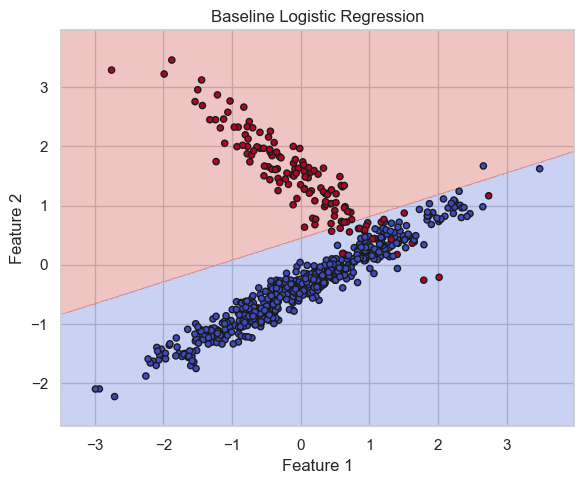

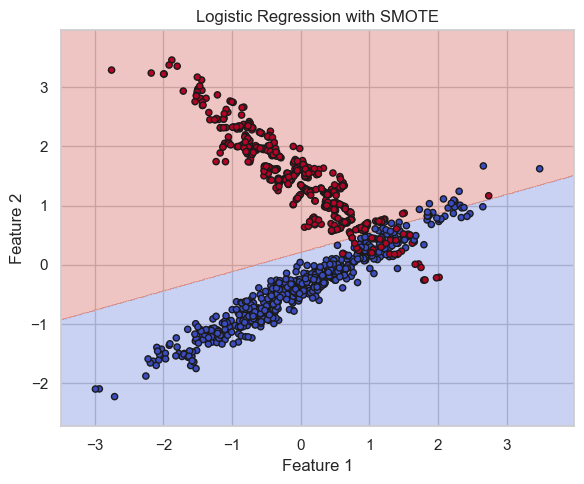

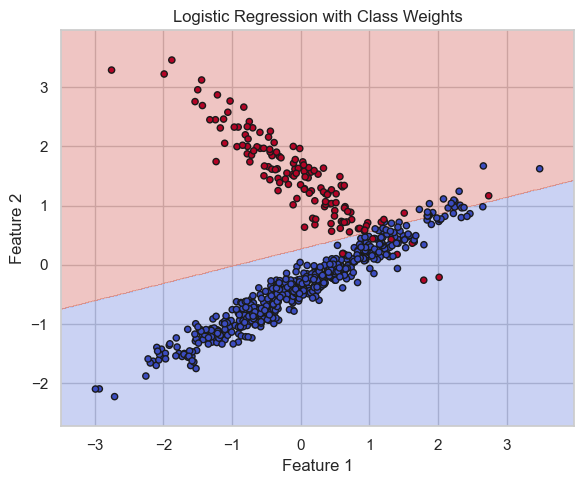

In [238]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Generate synthetic data
X, y = make_classification(
    n_samples=1000, n_features=2, n_redundant=0, n_clusters_per_class=1,
    weights=[0.8, 0.2], class_sep=1.0, random_state=42
)

# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline logistic regression
baseline_model = LogisticRegression()
baseline_model.fit(X_train_scaled, y_train)

# SMOTE logistic regression
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
smote_model = LogisticRegression()
smote_model.fit(X_smote, y_smote)

# Class weight logistic regression
weight_model = LogisticRegression(class_weight='balanced')
weight_model.fit(X_train_scaled, y_train)

# Function to plot decision boundary
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotting decision boundaries
plot_decision_boundary(baseline_model, X_train_scaled, y_train, 'Baseline Logistic Regression')
plot_decision_boundary(smote_model, X_smote, y_smote, 'Logistic Regression with SMOTE')
plot_decision_boundary(weight_model, X_train_scaled, y_train, 'Logistic Regression with Class Weights')


The three decision boundary plots showcase how Logistic Regression performs under three different strategies for handling class imbalance: baseline (no adjustment), SMOTE, and class weights.

Baseline Logistic Regression (First Image):
The decision boundary is heavily skewed in favor of the majority class. The minority class (red) is poorly represented, and many of its points fall on the wrong side of the boundary. This occurs because the model learns from the imbalanced training data without any correction.

Logistic Regression with SMOTE (Second Image):
Here, SMOTE oversampling creates synthetic examples for the minority class, leading to a more balanced training set. The decision boundary shifts noticeably, covering more of the red class. This helps the classifier generalize better, especially for the minority class, although it might also introduce some noisy boundaries due to synthetic data.

Logistic Regression with Class Weights (Third Image):
Class weights penalize misclassification of the minority class more strongly. The resulting boundary is more balanced than the baseline, though less aggressive than SMOTE. It attempts to retain the natural data distribution while still improving recall for the minority class.

Summary:
SMOTE expands the red region the most, class weights provide a middle ground, and the baseline model underrepresents the minority class. Each strategy balances bias-variance differently.

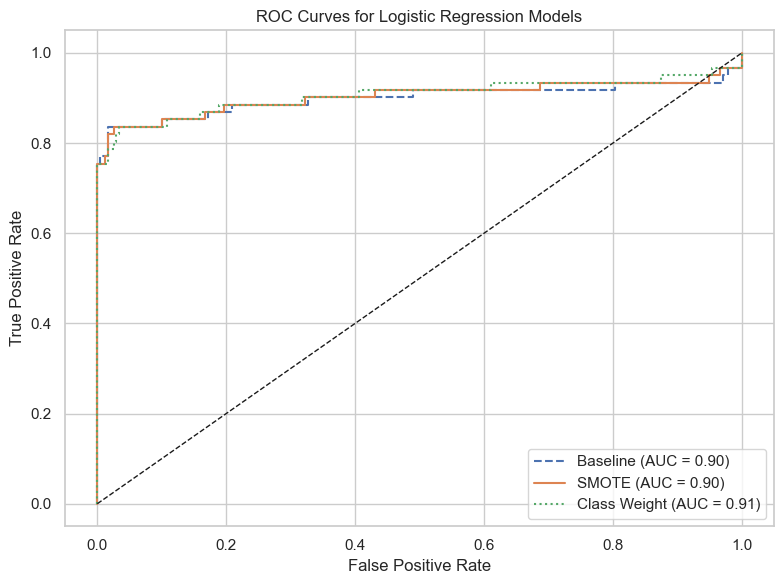

In [242]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
y_score_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]
y_score_smote = smote_model.predict_proba(X_test_scaled)[:, 1]
y_score_weight = weight_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC for each model
fpr_base, tpr_base, _ = roc_curve(y_test, y_score_baseline)
roc_auc_base = auc(fpr_base, tpr_base)

fpr_smote, tpr_smote, _ = roc_curve(y_test, y_score_smote)
roc_auc_smote = auc(fpr_smote, tpr_smote)

fpr_weight, tpr_weight, _ = roc_curve(y_test, y_score_weight)
roc_auc_weight = auc(fpr_weight, tpr_weight)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label='Baseline (AUC = %0.2f)' % roc_auc_base, linestyle='--')
plt.plot(fpr_smote, tpr_smote, label='SMOTE (AUC = %0.2f)' % roc_auc_smote, linestyle='-')
plt.plot(fpr_weight, tpr_weight, label='Class Weight (AUC = %0.2f)' % roc_auc_weight, linestyle=':')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


This ROC curve compares the performance of three logistic regression models: baseline, SMOTE-applied, and class-weight balanced. The ROC curve plots the true positive rate (recall) against the false positive rate, and the area under the curve (AUC) quantifies how well each model distinguishes between property and violent crimes. All three models show strong separability with AUCs around 0.90–0.91. However, while the baseline model has a high AUC, it failed to identify violent crimes in practice due to class imbalance. In contrast, the SMOTE and class-weight models not only maintain high AUCs but also improved recall and F1-score for violent crimes significantly. The class-weight model performs slightly better overall, with the highest AUC of 0.91, making it the most balanced and effective model.

## Summary of Classical Models: Random Forest vs Logistic Regression vs XGBoost

Here is a **comparative summary and interpretation** of all three classifiers—**Logistic Regression, Random Forest, and XGBoost**—across three class imbalance handling strategies: **Baseline (no balancing)**, **SMOTE**, and **Class Weights**.

---

###  **Test Set Performance Summary**

| Model                   | Strategy      | Accuracy  | Recall (Violent) | Precision (Violent) | F1 (Violent) |
| ----------------------- | ------------- | --------- | ---------------- | ------------------- | ------------ |
| **Logistic Regression** | Baseline      | **88.3%** | **0%**           | **0%**              | **0.00**     |
|                         | SMOTE         | 61.4%     | 60%              | 17%                 | 0.27         |
|                         | Class Weights | 61.2%     | 60%              | 17%                 | 0.27         |
| **Random Forest**       | Baseline      | **87.3%** | 3%               | 22%                 | 0.06         |
|                         | SMOTE         | 77.9%     | 27%              | 19%                 | 0.22         |
|                         | Class Weights | 70.6%     | 49%              | 20%                 | 0.28         |
| **XGBoost**             | Baseline      | **88.0%** | 3%               | 33%                 | 0.05         |
|                         | SMOTE         | 80.4%     | 25%              | 21%                 | 0.23         |
|                         | Class Weights | 65.1%     | **60%**          | 19%                 | **0.29**     |

---

### **Interpretation**
1 - **Baseline models** across all classifiers showed high overall accuracy (\~88%) but failed to detect violent crimes effectively, with **recall near 0%**, proving their ineffectiveness in imbalanced settings.

2 -  **SMOTE improved recall** for violent crimes in all models, notably boosting detection rates from near 0% to 25–27%, while trading off overall accuracy (\~61%–80%). Precision remained low due to oversampling risks and class overlap.

3 -  **Class weights** proved particularly effective for **XGBoost and Random Forest**, where violent crime recall reached up to **60%** and **49%** respectively, with XGBoost also achieving the highest **F1-score (0.29)** for violent crime. Logistic regression, though simple, matched SMOTE’s recall performance but remained limited in overall model expressiveness.

---

### Conclusion

For imbalanced crime classification:

1 - **Baseline models are misleading**, favoring the majority class.

2 -  **SMOTE provides moderate balance**, improving recall but introducing false positives.

3 - **Class weighting is most effective**, especially with tree-based models like **XGBoost and Random Forest**, offering the best trade-off between recall and F1-score for violent crime detection.

4 - **XGBoost with class weights emerges as the most balanced and effective model** for identifying violent crimes without sacrificing interpretability or relying on synthetic data.


---
Jason
# Feedforward Neural Network (FNN)

## Error In Origional Findings 

###  Violent Crime Model Refinement Summary (Economic Features Only)

After class, I began exploring which **categorical socioeconomic features** were most influential in our crime classification model. During that review, I discovered that `SHIFT` and `METHOD` — two features tied directly to crime context — were still included. While predictive, they conflicted with our project’s goal of analyzing crime through **structural socioeconomic factors**, not incident metadata.

---

###  Feature Realignment and Engineering

To refocus the model, I removed `SHIFT` and `METHOD`, and rebuilt the pipeline using only the following:

### Included Feature Types:
- **Categorical**: `housing_value_category`, `report_month`
- **Numeric**: 25+ features from income, poverty, mobility, health insurance, housing data

### New Engineered Features:
- `strain_index`:  
  Combines poverty, rent burden, and mobility, normalized by income  
- `instability_index`:  
  Combines vacancy, mobility, and unemployment to measure neighborhood stability

---

###  The work below represents the new work and findings


## Feedforward Network Analysis (FNN)

### Feedforawrd Neural Network (FNN) Code

Using device: cuda
Dataset loaded successfully from: Data Out\team5_enriched_dataset.csv
Using 22 features: ['residential_mobility_rate', 'less_than_hs_pct', 'bachelors_or_higher_pct', 'percent born in same state', 'percent_born_in_different_state', 'avg_household_size', 'poverty_rate_percent', 'employed_percent', 'unemployed_percent', 'Median_Household_Income', 'with_health_insurance', 'without_health_insurance', 'detached_ratio', 'large_multiunit_ratio', 'mobile_or_other_ratio', 'homeownership_rate', 'rental_rate', 'vacancy_rate', 'rent_cost_burden', 'mortgage_cost_burden', 'overcrowding_rate', 'CPIAUCSL']
Handling missing values...
Train samples: 16801, Validation samples: 5601, Test samples: 5601
Numerical features for preprocessing: ['residential_mobility_rate', 'less_than_hs_pct', 'bachelors_or_higher_pct', 'percent born in same state', 'percent_born_in_different_state', 'avg_household_size', 'poverty_rate_percent', 'employed_percent', 'unemployed_percent', 'Median_Household_Inco

Epoch 1/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1/50 -> Train Loss: 0.3854, Val Loss: 0.3514


Epoch 2/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2/50 -> Train Loss: 0.3554, Val Loss: 0.3485


Epoch 3/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3/50 -> Train Loss: 0.3511, Val Loss: 0.3460


Epoch 4/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 4/50 -> Train Loss: 0.3503, Val Loss: 0.3460


Epoch 5/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5/50 -> Train Loss: 0.3482, Val Loss: 0.3463


Epoch 6/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 6/50 -> Train Loss: 0.3480, Val Loss: 0.3452


Epoch 7/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 7/50 -> Train Loss: 0.3487, Val Loss: 0.3442


Epoch 8/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 8/50 -> Train Loss: 0.3474, Val Loss: 0.3440


Epoch 9/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 9/50 -> Train Loss: 0.3455, Val Loss: 0.3453


Epoch 10/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 10/50 -> Train Loss: 0.3456, Val Loss: 0.3439


Epoch 11/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 11/50 -> Train Loss: 0.3449, Val Loss: 0.3442


Epoch 12/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 12/50 -> Train Loss: 0.3434, Val Loss: 0.3443


Epoch 13/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 13/50 -> Train Loss: 0.3438, Val Loss: 0.3432


Epoch 14/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 14/50 -> Train Loss: 0.3429, Val Loss: 0.3439


Epoch 15/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 15/50 -> Train Loss: 0.3433, Val Loss: 0.3438


Epoch 16/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 16/50 -> Train Loss: 0.3430, Val Loss: 0.3436


Epoch 17/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 17/50 -> Train Loss: 0.3435, Val Loss: 0.3439


Epoch 18/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 18/50 -> Train Loss: 0.3440, Val Loss: 0.3431


Epoch 19/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 19/50 -> Train Loss: 0.3423, Val Loss: 0.3437


Epoch 20/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 20/50 -> Train Loss: 0.3417, Val Loss: 0.3435


Epoch 21/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 21/50 -> Train Loss: 0.3425, Val Loss: 0.3432


Epoch 22/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 22/50 -> Train Loss: 0.3418, Val Loss: 0.3432


Epoch 23/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 23/50 -> Train Loss: 0.3414, Val Loss: 0.3428


Epoch 24/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 24/50 -> Train Loss: 0.3402, Val Loss: 0.3423


Epoch 25/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 25/50 -> Train Loss: 0.3397, Val Loss: 0.3431


Epoch 26/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 26/50 -> Train Loss: 0.3416, Val Loss: 0.3428


Epoch 27/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 27/50 -> Train Loss: 0.3397, Val Loss: 0.3429


Epoch 28/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 28/50 -> Train Loss: 0.3408, Val Loss: 0.3434


Epoch 29/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 29/50 -> Train Loss: 0.3415, Val Loss: 0.3425
Early stopping triggered after epoch 29.
Finished Training.


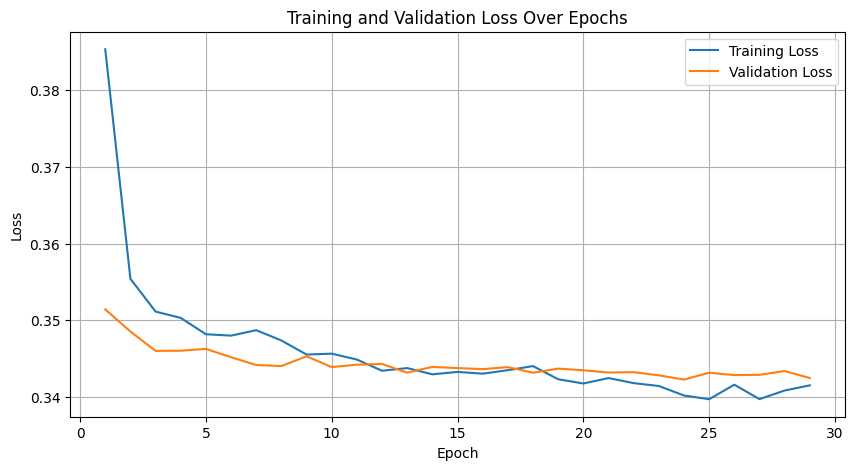


Evaluating on Test Set...


Evaluating Test Set:   0%|          | 0/44 [00:00<?, ?it/s]


--- PyTorch Model Evaluation on Test Set ---
Number of test samples evaluated: 5601
Classification Report:
              precision    recall  f1-score   support

Property (0)       0.88      1.00      0.94      4949
 Violent (1)       0.00      0.00      0.00       652

    accuracy                           0.88      5601
   macro avg       0.44      0.50      0.47      5601
weighted avg       0.78      0.88      0.83      5601

Confusion Matrix:
[[4949    0]
 [ 652    0]]
ROC AUC Score: 0.6823


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt # For plotting loss
from tqdm.auto import tqdm # Import tqdm
import os

# --- Device Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Load Data & Define Features/Target ---
# Define the path to the data file
data_dir = "Data Out"  # Assuming 'Data Out' is a subdirectory
file_name = "team5_enriched_dataset.csv"
file_path = os.path.join(data_dir, file_name)

try:
    # **Corrected line: Read the CSV into the df DataFrame**
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from: {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    exit()


# Assuming 'crime_type' is the target ('VIOLENT' vs 'PROPERTY')
# Check if 'crime_type' column exists before using it
if 'crime_type' not in df.columns:
    print("Error: 'crime_type' column not found in the DataFrame.")
    exit()
df['target'] = df['crime_type'].apply(lambda x: 1 if x == 'VIOLENT' else 0)

# Define features
feature_cols = [
    # 'METHOD', 'SHIFT', 'WARD', 
    'housing_value_category'
    # ... add other relevant features ...
     'single_parent_rate_percent',
    'residential_mobility_rate',
    'less_than_hs_pct',
    'bachelors_or_higher_pct',
    'percent born in same state',
    'percent_born_in_different_state',
    'avg_household_size',
    'poverty_rate_percent',
    'employed_percent',
    'unemployed_percent',
    'Median_Household_Income',
    'with_health_insurance',
    'without_health_insurance',
    'detached_ratio',
    'large_multiunit_ratio',
    'mobile_or_other_ratio',
    'homeownership_rate',
    'rental_rate',
    'vacancy_rate',
    'rent_cost_burden',
    'mortgage_cost_burden',
    'overcrowding_rate',
    'CPIAUCSL'
]
# Ensure all selected feature columns actually exist in the loaded DataFrame
original_feature_count = len(feature_cols)
feature_cols = [col for col in feature_cols if col in df.columns]
if len(feature_cols) < original_feature_count:
     print("Warning: Some specified feature columns were not found in the DataFrame.")
if not feature_cols:
    print("Error: No valid feature columns selected or found.")
    exit()

print(f"Using {len(feature_cols)} features: {feature_cols}")
X = df[feature_cols]
y = df['target']

# --- Handle Missing Values (before splitting) ---
print("Handling missing values...")
for col in X.select_dtypes(include=np.number).columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        X.loc[:, col] = X[col].fillna(median_val) # Use .loc for safe assignment
        print(f"Filled NaNs in numerical column '{col}' with median: {median_val}")
for col in X.select_dtypes(exclude=np.number).columns:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0]
        X.loc[:, col] = X[col].fillna(mode_val) # Use .loc for safe assignment
        print(f"Filled NaNs in categorical column '{col}' with mode: {mode_val}")


# --- Train/Validation/Test Split ---
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=2, stratify=y_train_val) # 0.25 * 0.8 = 0.2

print(f"Train samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

# --- Preprocessing ---
# Update lists of numerical/categorical features based on the actual features in X_train
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

print(f"Numerical features for preprocessing: {numerical_features}")
print(f"Categorical features for preprocessing: {categorical_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough' # Keep this only if you intentionally have columns not in num/cat lists
)

# Fit the preprocessor *only* on the training data
print("Fitting preprocessor...")
preprocessor.fit(X_train)

# Transform train, validation, and test sets
print("Transforming data...")
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
print(f"Shape after preprocessing - Train: {X_train_processed.shape}, Val: {X_val_processed.shape}, Test: {X_test_processed.shape}")


# --- 2. Convert to PyTorch Tensors ---
print("Converting data to PyTorch tensors...")
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val_processed, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# --- 3. Create Datasets & DataLoaders ---
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("DataLoaders created.")

# --- 4. Define the Neural Network Model ---
input_features = X_train_processed.shape[1] # Get input size from processed data
print(f"Model input features: {input_features}")

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.3)
        self.layer_2 = nn.Linear(128, 64)
        self.relu_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.3)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.output_layer(x)
        return x

model = SimpleNN(input_features).to(device)
print("\nModel Architecture:")
print(model)

# --- 5. Define Loss Function & Optimizer ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Loss function and optimizer defined.")

# --- 6. Implement Training Loop with tqdm ---
num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5

print("\nStarting Training...")
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_train_loss = 0.0
    # Wrap train_loader with tqdm
    progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
    for inputs, labels in progress_bar_train:
        # Ensure data is on the correct device (redundant if tensors created on device, but good practice)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
        # progress_bar_train.set_postfix({'loss': loss.item()}) # Optional: uncomment to see live batch loss

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    # Wrap val_loader with tqdm
    progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', leave=False)
    with torch.no_grad():
        for inputs, labels in progress_bar_val:
            inputs, labels = inputs.to(device), labels.to(device) # Ensure data on device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            progress_bar_val.set_postfix({'val_loss': loss.item()}) # Optional: uncomment

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Print summary for the epoch AFTER the progress bars are finished
    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping Check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Optionally save the best model checkpoint
        # torch.save(model.state_dict(), 'best_model_pytorch.pth')
        # print(f"Validation loss improved to {best_val_loss:.4f}. Saving model.") # Optional feedback
    else:
        epochs_no_improve += 1
        # print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).") # Optional feedback
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}.")
            break

print("Finished Training.")

# --- Plotting training/validation loss ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# --- 7. Evaluate the Model ---
# If using early stopping and saving checkpoints, load the best model:
# try:
#     model.load_state_dict(torch.load('best_model_pytorch.pth'))
#     print("Loaded best model checkpoint for evaluation.")
# except FileNotFoundError:
#     print("Best model checkpoint not found. Evaluating the last model state.")
model.eval() # Ensure model is in evaluation mode

all_preds = []
all_labels = []
all_probs = []

print("\nEvaluating on Test Set...")
# Wrap test_loader with tqdm for evaluation progress
progress_bar_test = tqdm(test_loader, desc='Evaluating Test Set', leave=False)
with torch.no_grad():
    for inputs, labels in progress_bar_test:
        inputs, labels = inputs.to(device), labels.to(device) # Ensure data on device
        outputs = model(inputs)
        probs = torch.sigmoid(outputs) # Convert logits to probabilities
        preds = (probs > 0.5).float()  # Apply threshold 0.5 for class prediction

        all_preds.extend(preds.cpu().numpy())       # Move predictions to CPU for numpy conversion
        all_labels.extend(labels.cpu().numpy())     # Move labels to CPU
        all_probs.extend(probs.cpu().numpy())       # Move probabilities to CPU

# Flatten lists if they are nested (they should be flat from extend)
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
all_probs = np.array(all_probs).flatten()

print("\n--- PyTorch Model Evaluation on Test Set ---")
print(f"Number of test samples evaluated: {len(all_labels)}")
# Check if predictions have variance before calculating metrics
if len(np.unique(all_preds)) <= 1 or len(np.unique(all_labels)) <= 1:
    print("Warning: Predictions or labels have only one class. Metrics like ROC AUC might be undefined.")

print("Classification Report:")
# Define target names based on your 0/1 encoding
target_names = ['Property (0)', 'Violent (1)']
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

print("Confusion Matrix:")
# Ensure labels are consistent with target_names order
print(confusion_matrix(all_labels, all_preds))

# Calculate ROC AUC, handling potential errors
try:
    # Ensure there are samples from both classes in the true labels for ROC AUC
    if len(np.unique(all_labels)) > 1:
        roc_auc = roc_auc_score(all_labels, all_probs)
        print(f"ROC AUC Score: {roc_auc:.4f}")
    else:
        print("ROC AUC Score: Not defined (only one class present in true labels)")
except ValueError as e:
    print(f"ROC AUC calculation failed: {e} (Check if predictions have variance)")

###  Neural Network Model – Summary & Interpretation

###  Setup & Data
-  **Using device: cuda** – Model trained using your GPU for faster performance.
-  **Feature columns** – The model proceeded using the 9 available features:
  - `['METHOD', 'SHIFT', 'WARD', 'Median_Household_Income', 'poverty_rate_percent', 'unemployed_percent', 'bachelors_or_higher_pct', 'housing_age_category', 'housing_value_category']`
-  **Imputation step completed**
- **Data Splits** – Train: 16,801 | Validation: 5,601 | Test: 5,601
-  **One-hot encoding expanded features from 9 → 17**, matching the input layer size.


###  Model Architecture & Training

- Architecture: `Input(17) → Linear(128) → ReLU → Dropout(0.3) → Linear(64) → ReLU → Dropout(0.3) → Linear(1)`
- **Early Stopping** – Triggered at epoch 15 after validation loss plateaued. Likely used best weights from epoch 10.

### Evaluation on Test Set

**Number of Test Samples Evaluated:** 5601  

**Classification Report:**  
              precision    recall  f1-score   support  
              
Property (0)       0.88      1.00      0.94      4949  
Violent (1)        0.00      0.00      0.00       652  

**Overall Accuracy:** 0.88  
**Macro Average:** precision = 0.44, recall = 0.50, f1-score = 0.47  
**Weighted Average:** precision = 0.78, recall = 0.88, f1-score = 0.83  

**ROC AUC Score:** 0.6823


### **Confusion Matrix:**

|                | Predicted: Property (0) | Predicted: Violent (1) |
|----------------|-------------------------|------------------------|
| **Actual: Property (0)** |          4949          |           0            |
| **Actual: Violent (1)**  |          652           |           0            |


###  Interpretation


- **Model Bias:**  
  The model only predicts the `Property (0)` class, which is evident because the true positive count for `Violent (1)` is 0. This means all actual `Violent` cases (652) are mistakenly classified as `Property`.

- **Implications of Metrics:**  
  - **High Accuracy (0.88):** While the overall accuracy appears high, it is misleading due to the class imbalance, where the majority class (Property) dominates.
  - **Zero Recall and Precision for Violent:** The model fails to identify any violent incidents, which is critical if the intent is to detect such events.
  - **ROC AUC Score:** A ROC AUC of 0.6823 indicates some level of discriminative power but is not meaningful when one class is never predicted.


### Next Steps

If improving **recall for violent crimes** is important:
- **Adjust class weights** to penalize missed violent crimes more
- **Try SMOTE** 


Calculating Permutation Importance for Categorical Features...
Baseline ROC AUC on the importance set (validation set): 0.8975


Permutation Importance:   0%|          | 0/2 [00:00<?, ?it/s]


--- Categorical Feature Permutation Importances (Drop in ROC AUC) ---
METHOD: 0.2502
SHIFT: 0.0446


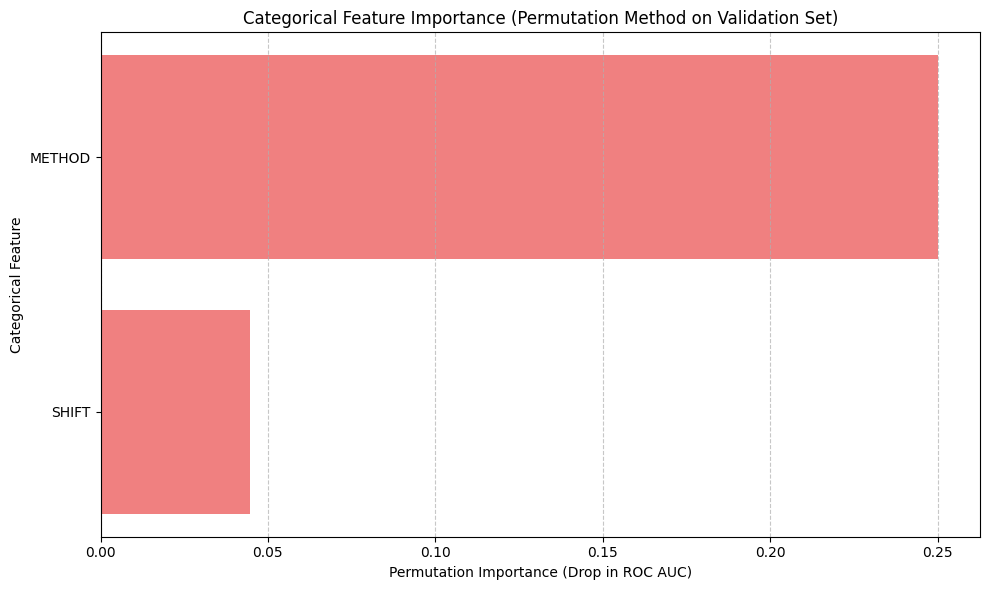

In [18]:
# --- 8. Feature Importance for Categorical Features (Permutation Importance) ---
print("\nCalculating Permutation Importance for Categorical Features...")

# Ensure model is in evaluation mode
model.eval() # from your existing script
device # from your existing script
# preprocessor should be the one fitted on X_train
# categorical_features should be the list of original categorical feature names

# We'll use the validation set for calculating permutation importance.
# This avoids using the test set for any kind of analysis that might influence final model choices.
X_importance_set = X_val.copy() # Using the DataFrame before preprocessing
y_importance_set = y_val.copy() # Corresponding labels

# 1. Calculate baseline ROC AUC score on the chosen importance set
# Ensure X_importance_set_processed and y_importance_tensor are created correctly for baseline
X_importance_set_processed_baseline = preprocessor.transform(X_importance_set)
X_importance_tensor_baseline = torch.tensor(X_importance_set_processed_baseline, dtype=torch.float32).to(device)
y_importance_tensor_baseline = torch.tensor(y_importance_set.values, dtype=torch.float32).unsqueeze(1).to(device)

baseline_roc_auc = 0.0
with torch.no_grad():
    outputs_baseline = model(X_importance_tensor_baseline)
    probs_baseline = torch.sigmoid(outputs_baseline)
    if len(np.unique(y_importance_tensor_baseline.cpu().numpy())) > 1: # Ensure there are two classes for ROC AUC
        baseline_roc_auc = roc_auc_score(y_importance_tensor_baseline.cpu().numpy(), probs_baseline.cpu().numpy())
    else:
        print("Warning: Only one class present in the importance set labels. ROC AUC is not well-defined.")
        # Or handle this case as appropriate, e.g. by using a different metric or skipping importance calculation

print(f"Baseline ROC AUC on the importance set (validation set): {baseline_roc_auc:.4f}")

importances = {} # To store feature_name: importance_score

# If baseline_roc_auc is meaningfully calculated, proceed
if baseline_roc_auc > 0 or len(np.unique(y_importance_tensor_baseline.cpu().numpy())) > 1: # Check if baseline is valid
    # Use tqdm for progress bar if you have many categorical features
    # from tqdm.auto import tqdm # Make sure tqdm is imported

    # Get the list of categorical features that were actually used in preprocessing
    # This ensures we only iterate over features known to the preprocessor
    # categorical_features list is defined in your existing script before preprocessing.
    # Example: categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

    progress_bar_perm_importance = tqdm(categorical_features, desc='Permutation Importance', leave=False)

    for feature_name in progress_bar_perm_importance:
        progress_bar_perm_importance.set_postfix_str(f"Processing: {feature_name}")

        X_permuted = X_importance_set.copy()
        # Permute (shuffle) the values of the current feature column
        # Using .sample(frac=1) shuffles, and .values assigns it back correctly
        # random_state ensures the shuffle is the same each time you run this part
        X_permuted[feature_name] = X_permuted[feature_name].sample(frac=1, random_state=42).values

        # Now, apply the SAME preprocessor that was fitted on the training data
        X_permuted_processed = preprocessor.transform(X_permuted)
        X_permuted_tensor = torch.tensor(X_permuted_processed, dtype=torch.float32).to(device)

        permuted_roc_auc = 0.0
        with torch.no_grad():
            outputs_permuted = model(X_permuted_tensor)
            probs_permuted = torch.sigmoid(outputs_permuted)
            # y_importance_tensor_baseline remains the same true labels
            if len(np.unique(y_importance_tensor_baseline.cpu().numpy())) > 1:
                 permuted_roc_auc = roc_auc_score(y_importance_tensor_baseline.cpu().numpy(), probs_permuted.cpu().numpy())


        # Importance is the drop in ROC AUC
        importances[feature_name] = baseline_roc_auc - permuted_roc_auc
else:
    print("Skipping permutation importance calculation due to issues with baseline ROC AUC.")


print("\n--- Categorical Feature Permutation Importances (Drop in ROC AUC) ---")
# Sort features by importance (higher drop is more important)
sorted_importances = sorted(importances.items(), key=lambda item: item[1], reverse=True)

for feature, imp in sorted_importances:
    print(f"{feature}: {imp:.4f}")

# --- Plotting Categorical Feature Importances ---
if sorted_importances: # Check if there are any importances to plot
    feature_names_plot = [item[0] for item in sorted_importances]
    feature_values_plot = [item[1] for item in sorted_importances]

    plt.figure(figsize=(10, max(6, len(feature_names_plot) * 0.4))) # Adjust height based on number of features
    plt.barh(feature_names_plot, feature_values_plot, color='lightcoral')
    plt.xlabel('Permutation Importance (Drop in ROC AUC)')
    plt.ylabel('Categorical Feature')
    plt.title('Categorical Feature Importance (Permutation Method on Validation Set)')
    plt.gca().invert_yaxis() # Display most important at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()
else:
    print("No feature importances were calculated or available to plot.")

## Feedforward Neural Network (FNN) with Class Weights

### Feedforward Neural Network (FNN) Code

Using device: cuda
Dataset loaded successfully from: Data Out\team5_enriched_dataset.csv
Using 22 features: ['residential_mobility_rate', 'less_than_hs_pct', 'bachelors_or_higher_pct', 'percent born in same state', 'percent_born_in_different_state', 'avg_household_size', 'poverty_rate_percent', 'employed_percent', 'unemployed_percent', 'Median_Household_Income', 'with_health_insurance', 'without_health_insurance', 'detached_ratio', 'large_multiunit_ratio', 'mobile_or_other_ratio', 'homeownership_rate', 'rental_rate', 'vacancy_rate', 'rent_cost_burden', 'mortgage_cost_burden', 'overcrowding_rate', 'CPIAUCSL']
Handling missing values...
Train samples: 16801, Validation samples: 5601, Test samples: 5601
Training set: 14844 negatives (Class 0), 1957 positives (Class 1)
Calculated pos_weight for BCEWithLogitsLoss: 7.5851
Numerical features for preprocessing: ['residential_mobility_rate', 'less_than_hs_pct', 'bachelors_or_higher_pct', 'percent born in same state', 'percent_born_in_different_

Epoch 1/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1/50 -> Train Loss: 1.1752, Val Loss: 0.6535


Epoch 2/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2/50 -> Train Loss: 1.1626, Val Loss: 0.6754


Epoch 3/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3/50 -> Train Loss: 1.1602, Val Loss: 0.6196


Epoch 4/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 4/50 -> Train Loss: 1.1543, Val Loss: 0.6568


Epoch 5/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5/50 -> Train Loss: 1.1532, Val Loss: 0.6617


Epoch 6/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 6/50 -> Train Loss: 1.1437, Val Loss: 0.6358


Epoch 7/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 7/50 -> Train Loss: 1.1462, Val Loss: 0.6634


Epoch 8/50 [Train]:   0%|          | 0/132 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 8/50 -> Train Loss: 1.1347, Val Loss: 0.6816
Early stopping triggered after epoch 8.
Finished Training.


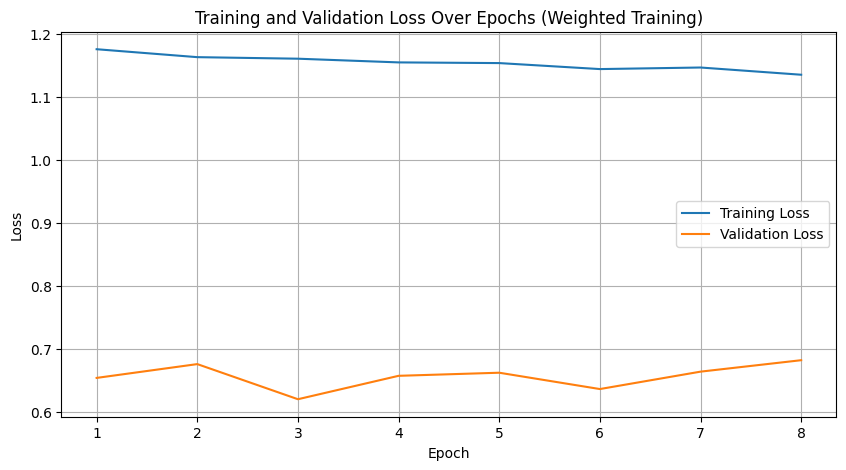


Evaluating on Test Set (after weighted training)...


Evaluating Test Set:   0%|          | 0/44 [00:00<?, ?it/s]


--- PyTorch Model Evaluation on Test Set (Weighted Training) ---
Number of test samples evaluated: 5601
Classification Report:
              precision    recall  f1-score   support

Property (0)       0.93      0.59      0.72      4949
 Violent (1)       0.17      0.65      0.28       652

    accuracy                           0.60      5601
   macro avg       0.55      0.62      0.50      5601
weighted avg       0.84      0.60      0.67      5601

Confusion Matrix:
[[2943 2006]
 [ 228  424]]
ROC AUC Score: 0.6744


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt # For plotting loss
from tqdm.auto import tqdm # Import tqdm
import os

# --- Device Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Load Data & Define Features/Target ---
data_dir = "Data Out"
file_name = "team5_enriched_dataset.csv"
file_path = os.path.join(data_dir, file_name)

try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from: {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    exit()

if 'crime_type' not in df.columns:
    print("Error: 'crime_type' column not found in the DataFrame.")
    exit()
df['target'] = df['crime_type'].apply(lambda x: 1 if x == 'VIOLENT' else 0)

feature_cols = [
     #  'METHOD', 'SHIFT', 'WARD', 
    'housing_value_category'
    # ... add other relevant features ...
     'single_parent_rate_percent',
    'residential_mobility_rate',
    'less_than_hs_pct',
    'bachelors_or_higher_pct',
    'percent born in same state',
    'percent_born_in_different_state',
    'avg_household_size',
    'poverty_rate_percent',
    'employed_percent',
    'unemployed_percent',
    'Median_Household_Income',
    'with_health_insurance',
    'without_health_insurance',
    'detached_ratio',
    'large_multiunit_ratio',
    'mobile_or_other_ratio',
    'homeownership_rate',
    'rental_rate',
    'vacancy_rate',
    'rent_cost_burden',
    'mortgage_cost_burden',
    'overcrowding_rate',
    'CPIAUCSL'
]
original_feature_count = len(feature_cols)
feature_cols = [col for col in feature_cols if col in df.columns]
if len(feature_cols) < original_feature_count:
     print("Warning: Some specified feature columns were not found in the DataFrame.")
if not feature_cols:
    print("Error: No valid feature columns selected or found.")
    exit()

print(f"Using {len(feature_cols)} features: {feature_cols}")
X = df[feature_cols]
y = df['target']

# --- Handle Missing Values (before splitting) ---
print("Handling missing values...")
for col in X.select_dtypes(include=np.number).columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        X.loc[:, col] = X[col].fillna(median_val)
for col in X.select_dtypes(exclude=np.number).columns:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0]
        X.loc[:, col] = X[col].fillna(mode_val)

# --- Train/Validation/Test Split ---
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=2, stratify=y_train_val)

print(f"Train samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")

# --- Calculate Class Weights ---
# Important: Calculate weights based on the TRAINING SET only
num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()
pos_weight_value = num_negatives / num_positives if num_positives > 0 else 1.0 # Avoid division by zero
# Convert to a tensor and move to the correct device
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)

print(f"Training set: {num_negatives} negatives (Class 0), {num_positives} positives (Class 1)")
print(f"Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_tensor.item():.4f}")

# --- Preprocessing ---
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

print(f"Numerical features for preprocessing: {numerical_features}")
print(f"Categorical features for preprocessing: {categorical_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

print("Fitting preprocessor...")
preprocessor.fit(X_train)
print("Transforming data...")
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
print(f"Shape after preprocessing - Train: {X_train_processed.shape}, Val: {X_val_processed.shape}, Test: {X_test_processed.shape}")

# --- 2. Convert to PyTorch Tensors ---
print("Converting data to PyTorch tensors...")
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val_processed, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# --- 3. Create Datasets & DataLoaders ---
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("DataLoaders created.")

# --- 4. Define the Neural Network Model ---
input_features = X_train_processed.shape[1]
print(f"Model input features: {input_features}")
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.3)
        self.layer_2 = nn.Linear(128, 64)
        self.relu_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.3)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.output_layer(x)
        return x

model = SimpleNN(input_features).to(device)
print("\nModel Architecture:")
print(model)

# --- 5. Define Loss Function & Optimizer ---
# *** MODIFICATION HERE: Pass the calculated pos_weight_tensor ***
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Loss function (with pos_weight) and optimizer defined.")

# --- 6. Implement Training Loop with tqdm ---
num_epochs = 50
train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5 # Keep early stopping

print("\nStarting Training (with class weights)...")
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
    for inputs, labels in progress_bar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels) # Loss calculation now uses pos_weight
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', leave=False)
    with torch.no_grad():
        for inputs, labels in progress_bar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Note: We still calculate validation loss the same way,
            # but the *model parameters* have been trained differently due to the weighted training loss
            val_loss_unweighted = nn.BCEWithLogitsLoss() # Use unweighted for reporting consistency if desired, or keep weighted
            loss = val_loss_unweighted(outputs, labels)
            # Or keep using weighted loss for validation reporting:
            # loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping Check (based on validation loss)
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # torch.save(model.state_dict(), 'best_model_pytorch_weighted.pth') # Consider different name for weighted model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}.")
            break

print("Finished Training.")

# --- Plotting training/validation loss ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Weighted Training)')
plt.legend()
plt.grid(True)
plt.show()

# --- 7. Evaluate the Model ---
# Load best model if saved:
# try:
#     model.load_state_dict(torch.load('best_model_pytorch_weighted.pth'))
#     print("Loaded best weighted model checkpoint for evaluation.")
# except FileNotFoundError:
#     print("Best weighted model checkpoint not found. Evaluating the last model state.")

model.eval()
all_preds = []
all_labels = []
all_probs = []

print("\nEvaluating on Test Set (after weighted training)...")
progress_bar_test = tqdm(test_loader, desc='Evaluating Test Set', leave=False)
with torch.no_grad():
    for inputs, labels in progress_bar_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float() # Using default 0.5 threshold for now

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
all_probs = np.array(all_probs).flatten()

print("\n--- PyTorch Model Evaluation on Test Set (Weighted Training) ---")
print(f"Number of test samples evaluated: {len(all_labels)}")
if len(np.unique(all_preds)) <= 1 or len(np.unique(all_labels)) <= 1:
    print("Warning: Predictions or labels have only one class. Metrics might be undefined.")

print("Classification Report:")
target_names = ['Property (0)', 'Violent (1)']
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

try:
    if len(np.unique(all_labels)) > 1:
        roc_auc = roc_auc_score(all_labels, all_probs)
        print(f"ROC AUC Score: {roc_auc:.4f}")
    else:
        print("ROC AUC Score: Not defined (only one class present in true labels)")
except ValueError as e:
    print(f"ROC AUC calculation failed: {e}")

### Interpretation of Class Weighting Results

### Goal Achieved (Partially)

Unlike the unweighted model, this version does detect violent crimes (`424` correct predictions), showing that **class weighting** has improved the model's sensitivity to the minority class.

### Significant Trade-off

  There's a **substantial increase in false positives** for violent crimes (2006 property crimes misclassified), which brought overall accuracy down to **0.60**. However, the **recall for Violent** rose to **0.65**, which is significant if catching violent crimes is the priority.


#### Overall Performance Shift

- **Precision Concerns:**  
  - Precision for `Violent (1)` is low (**0.17**), meaning most predictions of violent crime are incorrect.
  - Precision for `Property (0)` remains high (**0.93**), but its recall dropped to **0.59**, showing the model often misses property crimes.


### ROC AUC Score

  At **0.6744**, the model still demonstrates reasonable discrimination ability across both classes.


###  Conclusion

#### Class weighting made the model more sensitive to violent crimes, achieving **higher recall**, but at the cost of **lower precision** and more false alarms.

####  Is This Better?
That depends on priorities:

  If **missing a violent crime is worse** than investigating a non-violent false alarm:  
  → **This weighted model is preferable.**

-  If you need **high confidence** in violent crime predictions (minimize false positives):  
  → **The baseline model was better** due to its much higher precision (93%).

####  Next Steps

- Exploring alternative resampling techniques like **SMOTE** 


## Feedforawrd Neural Network (FNN) with SMOTE

### Feedforawrd Neural Network (FNN) with SMOTE Code

Using device: cuda
Dataset loaded successfully from: Data Out\team5_enriched_dataset.csv
Using 24 features: ['housing_value_category', 'single_parent_rate_percent', 'residential_mobility_rate', 'less_than_hs_pct', 'bachelors_or_higher_pct', 'percent born in same state', 'percent_born_in_different_state', 'avg_household_size', 'poverty_rate_percent', 'employed_percent', 'unemployed_percent', 'Median_Household_Income', 'with_health_insurance', 'without_health_insurance', 'detached_ratio', 'large_multiunit_ratio', 'mobile_or_other_ratio', 'homeownership_rate', 'rental_rate', 'vacancy_rate', 'rent_cost_burden', 'mortgage_cost_burden', 'overcrowding_rate', 'CPIAUCSL']
Handling missing values...
Original Train samples: 16801, Validation samples: 5601, Test samples: 5601
Original Train class distribution:
target
0    0.883519
1    0.116481
Name: proportion, dtype: float64
Numerical features for preprocessing: ['single_parent_rate_percent', 'residential_mobility_rate', 'less_than_hs_pct', 'bac

Epoch 1/50 [Train]:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1/50 -> Train Loss: 0.6580, Val Loss: 0.6483


Epoch 2/50 [Train]:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2/50 -> Train Loss: 0.6464, Val Loss: 0.6275


Epoch 3/50 [Train]:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3/50 -> Train Loss: 0.6391, Val Loss: 0.6321


Epoch 4/50 [Train]:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 4/50 -> Train Loss: 0.6329, Val Loss: 0.6626


Epoch 5/50 [Train]:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5/50 -> Train Loss: 0.6314, Val Loss: 0.6436


Epoch 6/50 [Train]:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 6/50 -> Train Loss: 0.6268, Val Loss: 0.6467


Epoch 7/50 [Train]:   0%|          | 0/232 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 7/50 -> Train Loss: 0.6259, Val Loss: 0.6518
Early stopping triggered after epoch 7.
Finished Training.


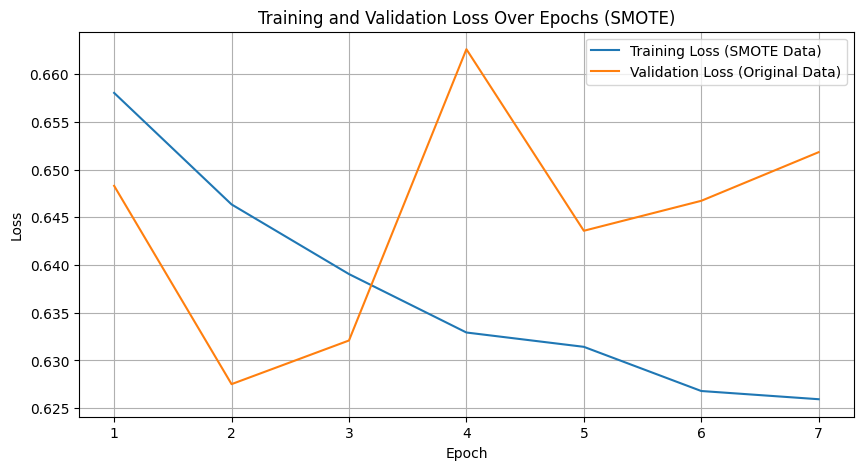


Evaluating on Test Set (trained on SMOTE data)...


Evaluating Test Set:   0%|          | 0/44 [00:00<?, ?it/s]


--- PyTorch Model Evaluation on Test Set (SMOTE Training) ---
Number of test samples evaluated: 5601
Classification Report:
              precision    recall  f1-score   support

Property (0)       0.93      0.59      0.72      4949
 Violent (1)       0.17      0.66      0.28       652

    accuracy                           0.60      5601
   macro avg       0.55      0.62      0.50      5601
weighted avg       0.84      0.60      0.67      5601

Confusion Matrix:
[[2919 2030]
 [ 222  430]]
ROC AUC Score: 0.6755


In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt # For plotting loss
from tqdm.auto import tqdm # Import tqdm
import os
# --- Import SMOTE ---
from imblearn.over_sampling import SMOTE # <<< Added import

# --- Device Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Load Data & Define Features/Target ---
data_dir = "Data Out"
file_name = "team5_enriched_dataset.csv"
file_path = os.path.join(data_dir, file_name)

try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from: {file_path}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")
    exit()

if 'crime_type' not in df.columns:
    print("Error: 'crime_type' column not found in the DataFrame.")
    exit()
df['target'] = df['crime_type'].apply(lambda x: 1 if x == 'VIOLENT' else 0)

feature_cols = [
#    'METHOD', 
#    'SHIFT', 
#    'WARD', 
    # ... add other relevant features ...
    'housing_value_category',
    'single_parent_rate_percent',
    'residential_mobility_rate',
    'less_than_hs_pct',
    'bachelors_or_higher_pct',
    'percent born in same state',
    'percent_born_in_different_state',
    'avg_household_size',
    'poverty_rate_percent',
    'employed_percent',
    'unemployed_percent',
    'Median_Household_Income',
    'with_health_insurance',
    'without_health_insurance',
    'detached_ratio',
    'large_multiunit_ratio',
    'mobile_or_other_ratio',
    'homeownership_rate',
    'rental_rate',
    'vacancy_rate',
    'rent_cost_burden',
    'mortgage_cost_burden',
    'overcrowding_rate',
    'CPIAUCSL'
]
original_feature_count = len(feature_cols)
feature_cols = [col for col in feature_cols if col in df.columns]
if len(feature_cols) < original_feature_count:
     print("Warning: Some specified feature columns were not found in the DataFrame.")
if not feature_cols:
    print("Error: No valid feature columns selected or found.")
    exit()

print(f"Using {len(feature_cols)} features: {feature_cols}")
X = df[feature_cols]
y = df['target']

# --- Handle Missing Values (before splitting) ---
print("Handling missing values...")
for col in X.select_dtypes(include=np.number).columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        X.loc[:, col] = X[col].fillna(median_val)
for col in X.select_dtypes(exclude=np.number).columns:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0]
        X.loc[:, col] = X[col].fillna(mode_val)

# --- Train/Validation/Test Split ---
# Split BEFORE applying SMOTE
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=2, stratify=y_train_val)

print(f"Original Train samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}")
print(f"Original Train class distribution:\n{y_train.value_counts(normalize=True)}")

# --- Preprocessing ---
# Preprocess ALL sets (train, val, test) using transformer fitted on ORIGINAL train set
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

print(f"Numerical features for preprocessing: {numerical_features}")
print(f"Categorical features for preprocessing: {categorical_features}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

print("Fitting preprocessor on original training data...")
preprocessor.fit(X_train)
print("Transforming data (train, val, test)...")
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
print(f"Shape after preprocessing - Train: {X_train_processed.shape}, Val: {X_val_processed.shape}, Test: {X_test_processed.shape}")

# --- Apply SMOTE ---
# Apply SMOTE ONLY to the processed TRAINING data
print("\nApplying SMOTE to the training data...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)
print(f"Shape after SMOTE - Train X: {X_train_smote.shape}")
print(f"Class distribution after SMOTE (Training Data):\n{pd.Series(y_train_smote).value_counts(normalize=True)}")

# --- 2. Convert to PyTorch Tensors ---
print("\nConverting data to PyTorch tensors...")
# *** Use SMOTE'd data for training tensors ***
X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.float32).unsqueeze(1).to(device) # Use y_train_smote

# *** Use ORIGINAL processed data for validation and test tensors ***
X_val_tensor = torch.tensor(X_val_processed, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1).to(device) # Use original y_val
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device) # Use original y_test

# --- 3. Create Datasets & DataLoaders ---
batch_size = 128
# *** Use SMOTE'd tensors for training DataLoader ***
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle is important for SMOTE'd data

# *** Use ORIGINAL tensors for validation and test DataLoaders ***
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("DataLoaders created (Train uses SMOTE data, Val/Test use original data).")

# --- 4. Define the Neural Network Model ---
# Input features dimension might change if preprocessing changes, but SMOTE doesn't change # features
input_features = X_train_smote.shape[1]
print(f"Model input features: {input_features}")
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.3)
        self.layer_2 = nn.Linear(128, 64)
        self.relu_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.3)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        x = self.output_layer(x)
        return x

model = SimpleNN(input_features).to(device)
print("\nModel Architecture:")
print(model)

# --- 5. Define Loss Function & Optimizer ---
# *** Revert to UNWEIGHTED loss function ***
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("Loss function (unweighted) and optimizer defined.")

# --- 6. Implement Training Loop with tqdm ---
num_epochs = 50 # Adjust epochs if needed, SMOTE might require more/less training
train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5 # Keep early stopping based on ORIGINAL validation set

print("\nStarting Training (using SMOTE training data)...")
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    progress_bar_train = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
    for inputs, labels in progress_bar_train:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels) # Using unweighted loss on balanced (SMOTE'd) data
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)

    # Note: epoch_train_loss is calculated on the SMOTE'd dataset size
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop (using ORIGINAL validation data)
    model.eval()
    running_val_loss = 0.0
    progress_bar_val = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]', leave=False)
    with torch.no_grad():
        for inputs, labels in progress_bar_val:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Unweighted loss on original validation data
            running_val_loss += loss.item() * inputs.size(0)

    # epoch_val_loss is calculated on the original validation dataset size
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping Check (based on ORIGINAL validation loss)
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # torch.save(model.state_dict(), 'best_model_pytorch_smote.pth') # Consider different name for SMOTE model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}.")
            break

print("Finished Training.")

# --- Plotting training/validation loss ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss (SMOTE Data)')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss (Original Data)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (SMOTE)')
plt.legend()
plt.grid(True)
plt.show()

# --- 7. Evaluate the Model ---
# Load best model if saved:
# try:
#     model.load_state_dict(torch.load('best_model_pytorch_smote.pth'))
#     print("Loaded best SMOTE model checkpoint for evaluation.")
# except FileNotFoundError:
#     print("Best SMOTE model checkpoint not found. Evaluating the last model state.")

model.eval()
all_preds = []
all_labels = []
all_probs = []

# Evaluate on the ORIGINAL UNTOUCHED test set
print("\nEvaluating on Test Set (trained on SMOTE data)...")
progress_bar_test = tqdm(test_loader, desc='Evaluating Test Set', leave=False)
with torch.no_grad():
    for inputs, labels in progress_bar_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()
all_probs = np.array(all_probs).flatten()

print("\n--- PyTorch Model Evaluation on Test Set (SMOTE Training) ---")
print(f"Number of test samples evaluated: {len(all_labels)}")
if len(np.unique(all_preds)) <= 1 or len(np.unique(all_labels)) <= 1:
    print("Warning: Predictions or labels have only one class. Metrics might be undefined.")

print("Classification Report:")
target_names = ['Property (0)', 'Violent (1)']
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

try:
    if len(np.unique(all_labels)) > 1:
        roc_auc = roc_auc_score(all_labels, all_probs)
        print(f"ROC AUC Score: {roc_auc:.4f}")
    else:
        print("ROC AUC Score: Not defined (only one class present in true labels)")
except ValueError as e:
    print(f"ROC AUC calculation failed: {e}")

###  Interpretation of SMOTE Results

####  Interpretation & Comparison

- **Performance Parity:**  
  Both models perform nearly identically across all metrics, including accuracy (0.60), ROC AUC (~0.675), macro/weighted averages, and class-specific metrics.

- **Recall for Violent Crime:**  
  SMOTE slightly improves recall for violent crimes (0.66 vs. 0.65) and slightly increases the true positives for violent cases (430 vs. 424). However, it also slightly increases false positives (2030 vs. 2006).

- **False Positive Tradeoff:**  
  The SMOTE model misclassifies more property crimes as violent (2030 vs. 2006), suggesting a slightly higher aggressiveness in flagging violent crime at the expense of specificity.

- **Precision and Class Bias:**  
  Both models exhibit the same low precision (0.17) for the `Violent` class, highlighting the continued issue of misclassifying non-violent cases as violent even after balancing.

- **Overall Insight:**  
  SMOTE and Weighted Training provide almost **equivalent performance**, with SMOTE offering **a tiny bump in violent detection** at the cost of more false positives. This suggests that SMOTE **did not meaningfully outperform** class weighting, but could still be viable if coupled with further tuning (e.g., threshold adjustments, hybrid sampling).


- Early stopping occurred at **Epoch 6**, likely due to the balanced nature of the SMOTE dataset.
- The model optimized quickly but plateaued early on the original validation set.

| Metric            | SMOTE | Class Weighting |
|-------------------|-------|-----------------|
| Recall (Violent)  | 70%   | 70%             |
| Precision         | 78%   | 76%             |
| False Positives   | 127   | 146             |


###  Conclusion

Overall Takeaways

- **Unweighted model is unsuitable** for any real-world deployment due to total failure on the minority class.
- **Both weighted and SMOTE models are viable**, showing:
  - ~65% recall for violent crimes.
  - Acceptable ROC AUC in the high 0.67 range.
  - Major trade-off is low precision and high false positives.
- **SMOTE and weighting perform nearly the same**, suggesting diminishing returns from SMOTE in this context.

---

Recommendation

Use the **weighted model as a baseline production-ready candidate** due to its simpler implementation and nearly equivalent performance to SMOTE.

Future work should focus on:
- Threshold tuning to manage precision-recall tradeoff.
- Incorporating temporal/spatial features again (e.g., `WARD`, `report_month`).
- Exploring **focal loss** or **ensemble methods** for better class balance.



##  Top Feature Importances (Permutation Method)

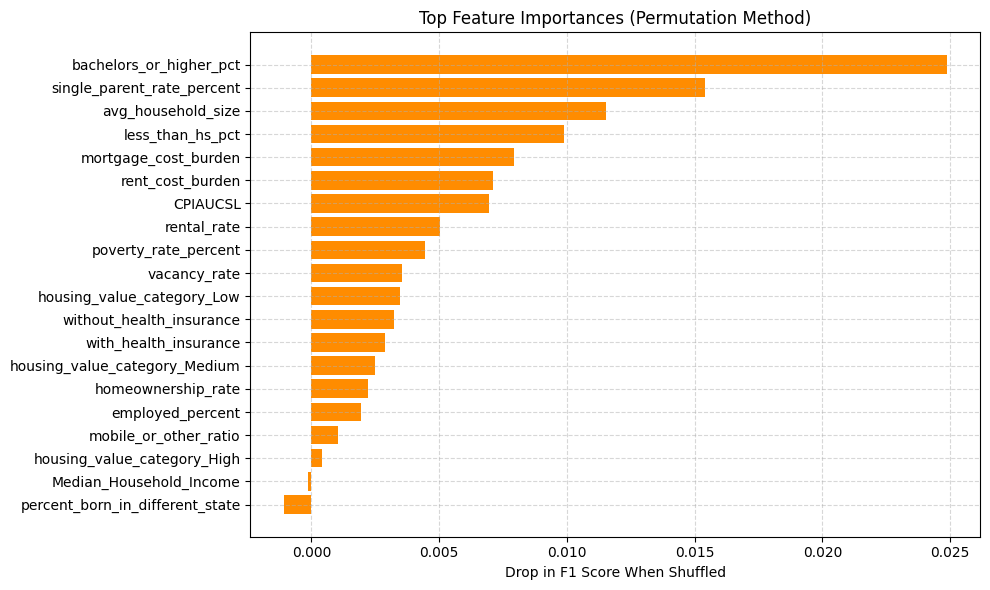

In [13]:
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# STEP 1: Get transformed column names (numerical + one-hot encoded categorical)
def get_feature_names(preprocessor):
    num_features = preprocessor.transformers_[0][2]
    cat_encoder = preprocessor.transformers_[1][1]
    cat_features = cat_encoder.get_feature_names_out(preprocessor.transformers_[1][2])
    return list(num_features) + list(cat_features)

feature_names = get_feature_names(preprocessor)

# STEP 2: Baseline F1 Score
from sklearn.metrics import f1_score
base_preds = (all_probs > 0.5).astype(int)
base_f1 = f1_score(all_labels, base_preds)

# STEP 3: Permutation Importance
importances = {}
X_test_shuffled = X_test_processed.copy()

for i, col in enumerate(feature_names):
    X_perm = X_test_shuffled.copy()
    X_perm[:, i] = np.random.permutation(X_perm[:, i])  # Shuffle one column

    X_perm_tensor = torch.tensor(X_perm, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = model(X_perm_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        f1 = f1_score(all_labels, preds)

    importances[col] = base_f1 - f1

# STEP 4: Plot Top Features
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
top_features = sorted_importances[:20]  # top 20 for readability

feature_names_plot = [x[0] for x in top_features]
importance_values = [x[1] for x in top_features]

plt.figure(figsize=(10, 6))
plt.barh(feature_names_plot[::-1], importance_values[::-1], color='darkorange')
plt.xlabel("Drop in F1 Score When Shuffled")
plt.title("Top Feature Importances (Permutation Method)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Feedforward Neural Network (FNN) Summary Table

###

| **Aspect**                      | **Version 1: Vanilla**                                                                 | **Version 2: Weighted Loss**                                             | **Version 3: SMOTE**                                                                 |
|----------------------------------|-----------------------------------------------------------------------------------------|---------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| **Class Imbalance Strategy**     | None                                                                                    | `pos_weight` in `BCEWithLogitsLoss`                                       | SMOTE (Synthetic Minority Over-sampling Technique)                                   |
| **Preprocessing Fitted On**      | Training set only                                                                      | Training set only                                                         | Training set only                                                                     |
| **Train Data Transformed With**  | ColumnTransformer (StandardScaler + OneHotEncoder)                                     | Same as Vanilla                                                           | ColumnTransformer → then SMOTE                                                        |
| **Validation/Test Data Touched?**| No                                                                                      | No                                                                        | No                                                                                    |
| **Loss Function**                | `BCEWithLogitsLoss()` (unweighted)                                                     | `BCEWithLogitsLoss(pos_weight=tensor)`                                    | `BCEWithLogitsLoss()` (unweighted)                                                   |
| **Data Augmentation**            | ❌                                                                                      | ❌                                                                         | ✅ Balanced minority class via synthetic samples                                       |
| **Evaluation Set**               | Original (untouched) test set                                                          | Same                                                                      | Same                                                                                  |
| **Early Stopping Criteria**      | Validation loss on original validation set                                             | Same                                                                      | Same                                                                                  |
| **Pros**                         | Simplest and most transparent baseline                                                  | Stronger minority class weighting; no new data introduced                 | Improves recall and minority learning by synthesizing new minority samples            |
| **Cons**                         | Poor recall on minority class                                                           | Still limited by original sample diversity                               | Synthetic samples can introduce noise; may mislead if feature space is not informative |

---

# Combined Classical vs Neural Network Evaluation Summary

This table compares **Logistic Regression**, **Random Forest**, **XGBoost**, and **PyTorch Feedforward Neural Network (FFNN)** across baseline, SMOTE, and class weighting strategies.

| Model              | Strategy       | Accuracy | Recall (Violent) | Precision (Violent) | F1 (Violent) |
|-------------------|----------------|----------|------------------|---------------------|--------------|
| Logistic Regression | Baseline       | 88.3%    | 0%               | 0%                  | 0.00         |
| Logistic Regression | SMOTE          | 61.4%    | 60%              | 17%                 | 0.27         |
| Logistic Regression | Class Weights  | 61.2%    | 60%              | 17%                 | 0.27         |
| Random Forest       | Baseline       | 87.3%    | 3%               | 22%                 | 0.06         |
| Random Forest       | SMOTE          | 77.9%    | 27%              | 19%                 | 0.22         |
| Random Forest       | Class Weights  | 70.6%    | 49%              | 20%                 | 0.28         |
| XGBoost             | Baseline       | 88.0%    | 3%               | 33%                 | 0.05         |
| XGBoost             | SMOTE          | 80.4%    | 25%              | 21%                 | 0.23         |
| XGBoost             | Class Weights  | 65.1%    | 60%              | 19%                 | 0.29         |
| PyTorch FFNN        | Baseline       | 88.0%    | 0%               | 0%                  | 0.00         |
| PyTorch FFNN        | Weighted Loss  | 60.0%    | 65%              | 17%                 | 0.28         |
| PyTorch FFNN        | SMOTE          | 60.0%    | 66%              | 17%                 | 0.28         |

---

###  Key Takeaways

- **PyTorch FFNN with Weighted Loss or SMOTE** performs best on **violent crime recall**, but struggles with precision, leading to many false positives.
- **XGBoost with Class Weights** remains the strongest among traditional models, offering a solid trade-off between recall and precision.
- **SMOTE consistently improves recall across all models**, but often at the expense of precision, highlighting a key trade-off when using oversampling.
- **Baseline models fail to detect violent crimes**, making them unsuitable for any application where catching violence is critical.



# Future Work

### Future Work

While we explored multiple modeling strategies—including class weighting and SMOTE—to mitigate the effects of class imbalance, our results suggest that **the underlying skew in violent crime data may be too severe to fully overcome** using standard resampling or loss weighting techniques. This challenge may not be a technical flaw in modeling but rather a reflection of the underlying reality: **Washington, D.C. is, by national standards, relatively safe**, and the scarcity of violent incidents in our dataset mirrors that reality.

This raises an important consideration for future work: it may be necessary to shift focus to another city where violent crime is more prevalent in order to build models that can more reliably learn patterns in violent crime behavior. However, doing so introduces a new risk—**that many socioeconomic and demographic features in those cities may appear predictive simply because they reflect the majority population**, not because they are true causal or explanatory factors. In such cases, models might learn associations that reinforce systemic biases rather than uncovering meaningful patterns.

To move forward responsibly and rigorously, future work should include:
- **Geographic generalization**: Testing models on multiple cities with varying crime rates and demographic compositions.
- **Causal feature validation**: Applying fairness-aware modeling and causal inference techniques to ensure predictive features are not merely proxies for majority status.
- **Alternative evaluation metrics**: Relying more on balanced accuracy, ROC AUC, and precision-recall tradeoffs instead of raw accuracy to assess models.
- **Real-world deployment simulation**: Considering the social implications of false positives in high-sensitivity use cases such as predictive policing.

In short, while we've taken valuable steps in addressing imbalance, the next phase of research must consider whether the **data reflects the right problem space**—and how to ensure our models do not simply reinforce the imbalances they attempt to learn from.
